<a href="https://colab.research.google.com/github/niranjan-sa/DataScience/blob/master/IEEE_Fraud_Transaction_Complete_EDA_and_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Data
(Tested works fine)

In [0]:
#Importing dependancies.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import os
import gc
#print (os.listdir('../input/ieee-fraud-detection/.'))
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from google.colab import drive

In [2]:
## Colab code
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
## Colab code
os.listdir('My Drive/DataScience/IEEE Fraud Detection/.')

['sample_submission.csv.zip',
 'test_identity.csv.zip',
 'test_transaction.csv.zip',
 'train_transaction.csv.zip',
 'train_identity.csv.zip',
 'Untitled',
 'To Dos.gsheet',
 'sub1.csv.zip',
 'sub1.csv',
 'train_processed.csv.zip',
 'test_processed.csv.zip',
 'processed_text.csv.zip',
 'processed_train.csv.zip',
 'processed_test.csv.zip',
 'xgb1.csv',
 'IEEE Fraud Transaction Complete EDA and Modelling.ipynb']

In [0]:
# Kaggle Kernels
#train_tr = pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv', nrows=10)
#train_id = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv', nrows=10)

In [0]:
import warnings
warnings.filterwarnings('ignore')

**# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage**


In [0]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
## Credits J. Howard, fastai (for this method)
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [0]:
## List of attributes specifically asked for the assignment
attr = [
"TransactionID",
"DeviceType",
"DeviceInfo",
"TransactionDT",
"TransactionAmt",
"ProductCD", 
"card4", 
"card6", 
"P_emaildomain",
"R_emaildomain",
"addr1", 
"addr2", 
"dist1", 
"dist2", 
"isFraud"]

In [0]:
## While testing on Kaggle kernels, please comment out this code and, run the code in the next cell instead.  
train_tr = pd.read_csv('My Drive/DataScience/IEEE Fraud Detection/train_transaction.csv.zip', nrows=10)
train_id = pd.read_csv('My Drive/DataScience/IEEE Fraud Detection/train_identity.csv.zip', nrows=10)

In [0]:
#Kaggle kernels code
#train_tr = pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv', nrows=10)
#train_id = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv', nrows=10)

In [11]:
"""
Looks like, we can fetch, TransactionID, isFraud, TransactionDT, TransactionAmt, ProductCD, card4, card6
P_emaildomain, R_emaildomain, addr1, addr2, dist2, dist2 from 'train_trainsaction.csv'.
"""
display_all(train_tr.head())

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   

  P_emaildomain  R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0           NaN            NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1     gmail.com            NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2   outlook.com            NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3     yahoo.com            NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4     gmail.com            NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

   C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  D7  D8  D9  \
0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN   
1  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
2  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
3  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN   
4  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   

    D10    D11  D12  D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8  \
0  13.0   13.0  NaN  NaN  NaN    0.0    T    T    T   M2    F    T  NaN  NaN   
1   0.0    NaN  NaN  NaN  NaN    0.0  NaN  NaN  NaN   M0    T    T  NaN  NaN   
2   0.0  315.0  NaN  NaN  NaN  315.0    T    T    T   M0    F    F    F    F   
3  84.0    NaN  NaN  NaN  NaN  111.0  NaN  NaN  NaN   M0    T    F  NaN  NaN   
4   NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

    M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  \
0  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
2    F  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  \
0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  \
0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
2  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
3  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0 

In [12]:
"""
We can fetch, DeviceType, DeviceInfo, from 'train_identity.csv'.
"""
display_all(train_id.head())

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  id_10  id_11     id_12  id_13  id_14  id_15     id_16  id_17  id_18  \
0    NaN    NaN  100.0  NotFound    NaN -480.0    New  NotFound  166.0    NaN   
1    NaN    NaN  100.0  NotFound   49.0 -300.0    New  NotFound  166.0    NaN   
2    0.0    0.0  100.0  NotFound   52.0    NaN  Found     Found  121.0    NaN   
3    NaN    NaN  100.0  NotFound   52.0    NaN    New  NotFound  225.0    NaN   
4    0.0    0.0  100.0  NotFound    NaN -300.0  Found     Found  166.0   15.0   

   id_19  id_20  id_21  id_22  id_23  id_24  id_25  id_26  id_27  id_28  \
0  542.0  144.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    New   
1  621.0  500.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    New   
2  410.0  142.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN  Found   
3  176.0  507.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    New   
4  529.0  575.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN  Found   

      id_29             id_30                id_31  id_32      id_33  \
0  NotFound       Android 7.0  samsung browser 6.2   32.0  2220x1080   
1  NotFound        iOS 11.1.2   mobile safari 11.0   32.0   1334x750   
2     Found               NaN          chrome 62.0    NaN        NaN   
3  NotFound               NaN          chrome 62.0    NaN        NaN   
4     Found  Mac OS X 10_11_6          chrome 62.0   24.0   1280x800   

            id_34 id_35 id_36 id_37 id_38 DeviceType  \
0  match_status:2     T     F     T     T     mobile   
1  match_status:1     T     F     F     T     mobile   
2             NaN     F     F     T     T    desktop   
3             NaN     F     F     T     T    desktop   
4  match_status:2     T     F     T     T    desktop   

                      DeviceInfo  
0  SAMSUNG SM-G892A Build/NRD90M  
1                     iOS Device  
2                        Windows  
3                            NaN  
4                          MacOS

 **Lets read the entire data frames for train data inside.**

In [0]:
## While testing on Kaggle kernels, please comment out this code and, run the code in the next cell instead.  
train_tr = pd.read_csv('My Drive/DataScience/IEEE Fraud Detection/train_transaction.csv.zip')
train_id = pd.read_csv('My Drive/DataScience/IEEE Fraud Detection/train_identity.csv.zip')

In [0]:
## Lets read the entire data frames for train data inside.
#Training data-only
## Kaggle kernels code
#train_tr = pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv')
#train_id = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv')

In [15]:
##Let's check if they both contain same rows
print (train_id.shape)
print (train_tr.shape)

(144233, 41)
(590540, 394)


The above mismatch in the rows shows that **we may not get identity information for all the transactions**. Let's dig deeper into this, by checking the number of unique transaction IDs both record. Besides it's also mentioned in the data description document. 

In [16]:
## Sneak peak into what we loaded
display_all(train_tr.describe())

TransactionID        isFraud  TransactionDT  TransactionAmt  \
count   5.905400e+05  590540.000000   5.905400e+05   590540.000000   
mean    3.282270e+06       0.034990   7.372311e+06      135.027176   
std     1.704744e+05       0.183755   4.617224e+06      239.162522   
min     2.987000e+06       0.000000   8.640000e+04        0.251000   
25%     3.134635e+06       0.000000   3.027058e+06       43.321000   
50%     3.282270e+06       0.000000   7.306528e+06       68.769000   
75%     3.429904e+06       0.000000   1.124662e+07      125.000000   
max     3.577539e+06       1.000000   1.581113e+07    31937.391000   

               card1          card2          card3          card5  \
count  590540.000000  581607.000000  588975.000000  586281.000000   
mean     9898.734658     362.555488     153.194925     199.278897   
std      4901.170153     157.793246      11.336444      41.244453   
min      1000.000000     100.000000     100.000000     100.000000   
25%      6019.000000     214.000000     150.000000     166.000000   
50%      9678.000000     361.000000     150.000000     226.000000   
75%     14184.000000     512.000000     150.000000     226.000000   
max     18396.000000     600.000000     231.000000     237.000000   

               addr1          addr2          dist1         dist2  \
count  524834.000000  524834.000000  238269.000000  37627.000000   
mean      290.733794      86.800630     118.502180    231.855423   
std       101.741072       2.690623     371.872026    529.053494   
min       100.000000      10.000000       0.000000      0.000000   
25%       204.000000      87.000000       3.000000      7.000000   
50%       299.000000      87.000000       8.000000     37.000000   
75%       330.000000      87.000000      24.000000    206.000000   
max       540.000000     102.000000   10286.000000  11623.000000   

                  C1             C2             C3             C4  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean       14.092458      15.269734       0.005644       4.092185   
std       133.569018     154.668899       0.150536      68.848459   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       0.000000       0.000000   
50%         1.000000       1.000000       0.000000       0.000000   
75%         3.000000       3.000000       0.000000       0.000000   
max      4685.000000    5691.000000      26.000000    2253.000000   

                  C5             C6             C7             C8  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean        5.571526       9.071082       2.848478       5.144574   
std        25.786976      71.508467      61.727304      95.378574   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       1.000000       0.000000       0.000000   
50%         0.000000       1.000000       0.000000       0.000000   
75%         1.000000       2.000000       0.000000       0.000000   
max       349.000000    2253.000000    2255.000000    3331.000000   

                  C9            C10            C11            C12  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean        4.480240       5.240343      10.241521       4.076227   
std        16.674897      95.581443      94.336292      86.666218   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       1.000000       0.000000   
50%         1.000000       0.000000       1.000000       0.000000   
75%         2.000000       0.000000       2.000000       0.000000   
max       210.000000    3257.000000    3188.000000    3188.000000   

                 C13            C14             D1             D2  \
count  590540.000000  590540.000000  589271.000000  309743.000000   
mean       32.539918       8.295215      94.347568     169.563231   
std       129.364844      49.544262     157.660387     177.315865   

In [17]:
display_all(train_id.describe())

TransactionID          id_01          id_02         id_03  \
count   1.442330e+05  144233.000000  140872.000000  66324.000000   
mean    3.236329e+06     -10.170502  174716.584708      0.060189   
std     1.788496e+05      14.347949  159651.816856      0.598231   
min     2.987004e+06    -100.000000       1.000000    -13.000000   
25%     3.077142e+06     -10.000000   67992.000000      0.000000   
50%     3.198818e+06      -5.000000  125800.500000      0.000000   
75%     3.392923e+06      -5.000000  228749.000000      0.000000   
max     3.577534e+06       0.000000  999595.000000     10.000000   

              id_04          id_05          id_06        id_07        id_08  \
count  66324.000000  136865.000000  136865.000000  5155.000000  5155.000000   
mean      -0.058938       1.615585      -6.698710    13.285354   -38.600388   
std        0.701015       5.249856      16.491104    11.384207    26.084899   
min      -28.000000     -72.000000    -100.000000   -46.000000  -100.000000   
25%        0.000000       0.000000      -6.000000     5.000000   -48.000000   
50%        0.000000       0.000000       0.000000    14.000000   -34.000000   
75%        0.000000       1.000000       0.000000    22.000000   -23.000000   
max        0.000000      52.000000       0.000000    61.000000     0.000000   

              id_09         id_10          id_11          id_13         id_14  \
count  74926.000000  74926.000000  140978.000000  127320.000000  80044.000000   
mean       0.091023     -0.301124      99.745325      48.053071   -344.507146   
std        0.983842      2.789446       1.127602      11.774858     93.695502   
min      -36.000000   -100.000000      90.000000      10.000000   -660.000000   
25%        0.000000      0.000000     100.000000      49.000000   -360.000000   
50%        0.000000      0.000000     100.000000      52.000000   -300.000000   
75%        0.000000      0.000000     100.000000      52.000000   -300.000000   
max       25.000000      0.000000     100.000000      64.000000    720.000000   

               id_17         id_18          id_19          id_20        id_21  \
count  139369.000000  45113.000000  139318.000000  139261.000000  5159.000000   
mean      189.451377     14.237337     353.128174     403.882666   368.269820   
std        30.375360      1.561302     141.095343     152.160327   198.847038   
min       100.000000     10.000000     100.000000     100.000000   100.000000   
25%       166.000000     13.000000     266.000000     256.000000   252.000000   
50%       166.000000     15.000000     341.000000     472.000000   252.000000   
75%       225.000000     15.000000     427.000000     533.000000   486.500000   
max       229.000000     29.000000     671.000000     661.000000   854.000000   

             id_22        id_24        id_25        id_26         id_32  
count  5169.000000  4747.000000  5132.000000  5163.000000  77586.000000  
mean     16.002708    12.800927   329.608924   149.070308     26.508597  
std       6.897665     2.372447    97.461089    32.101995      3.737502  
min      10.000000    11.000000   100.000000   100.000000      0.000000  
25%      14.000000    11.000000   321.000000   119.000000     24.000000  
50%      14.000000    11.000000   321.000000   149.000000     24.000000  
75%      14.000000    15.000000   371.000000   169.000000     32.000000  
max      44.000000    26.000000   548.000000   216.000000     32.000000

The `describe()` function presents data without nulls. So, let's explore null values.

# Null Values (all data) and Merging Data Frames

1.   Find out null values in entire training data set.
2.   Merge two data sets into one frame
3.   Slice data frame to get the subset of our important attributes.
4.   Reduce memory consumption by changing data types.
5.   A quick look at the class sizes. (Found that the classes are imbalanced)

Let's examine how many null values we have in both the data frames.

In [18]:
display_all(train_id.isna().sum()*100/train_id.shape[0])

TransactionID     0.000000
id_01             0.000000
id_02             2.330257
id_03            54.016071
id_04            54.016071
id_05             5.108401
id_06             5.108401
id_07            96.425922
id_08            96.425922
id_09            48.052110
id_10            48.052110
id_11             2.256765
id_12             0.000000
id_13            11.726165
id_14            44.503685
id_15             2.251912
id_16            10.325654
id_17             3.372321
id_18            68.722137
id_19             3.407681
id_20             3.447200
id_21            96.423149
id_22            96.416215
id_23            96.416215
id_24            96.708798
id_25            96.441868
id_26            96.420375
id_27            96.416215
id_28             2.256765
id_29             2.256765
id_30            46.222432
id_31             2.739318
id_32            46.207872
id_33            49.187079
id_34            46.056034
id_35             2.251912
id_36             2.251912
i

For us, from above, `DeviceType` and `DeviceInfo` are important attributes. They contain nulls, so we will have to deal with them later. 

In [19]:
display_all(train_tr.isna().sum()*100/train_tr.shape[0])

TransactionID      0.000000
isFraud            0.000000
TransactionDT      0.000000
TransactionAmt     0.000000
ProductCD          0.000000
card1              0.000000
card2              1.512683
card3              0.265012
card4              0.267044
card5              0.721204
card6              0.266028
addr1             11.126427
addr2             11.126427
dist1             59.652352
dist2             93.628374
P_emaildomain     15.994852
R_emaildomain     76.751617
C1                 0.000000
C2                 0.000000
C3                 0.000000
C4                 0.000000
C5                 0.000000
C6                 0.000000
C7                 0.000000
C8                 0.000000
C9                 0.000000
C10                0.000000
C11                0.000000
C12                0.000000
C13                0.000000
C14                0.000000
D1                 0.214888
D2                47.549192
D3                44.514851
D4                28.604667
D5                52

Looks like a lot of variables have null values. Nevertheless, our primary key to join two dataframes is free of null values. So, let's join and subset our attributes of interest. Therefore, performing an outer join.

In [0]:
data = train_id.merge(train_tr, how='outer', on='TransactionID')

In [21]:
data.shape

(590540, 434)

Our merge operation looks good as number of rows matches the max number of rows among either data frames.

In [22]:
"""
As we no more need earlier data frames, let's clean up our memory.
"""
train_id = None
train_tr = None
gc.collect()

56

Now let's slice out our data frame and remove the extraneous columns. Therefore, we are free to experiment on our limited data.

In [23]:
df = data[attr]
data = None
gc.collect()

7

Let's check the data types and see if our attributes are represented properly in memory.

In [24]:
display_all(df.dtypes)

TransactionID       int64
DeviceType         object
DeviceInfo         object
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card4              object
card6              object
P_emaildomain      object
R_emaildomain      object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
isFraud             int64
dtype: object

Let's optimize some of the attributes and their data sizes.

In [25]:
df = reduce_mem_usage(df)
display_all(df.dtypes)

Memory usage of dataframe is 72.09 MB --> 46.74 MB (Decreased by 35.2%)


TransactionID       int32
DeviceType         object
DeviceInfo         object
TransactionDT       int32
TransactionAmt    float16
ProductCD          object
card4              object
card6              object
P_emaildomain      object
R_emaildomain      object
addr1             float16
addr2             float16
dist1             float16
dist2             float16
isFraud              int8
dtype: object

Reduced the memory foot-print.

NuLL Values (for our subset)

In [26]:
print (pd.concat([df.isna().sum()*100/df.shape[0], df.dtypes], axis=1))

                        0        1
TransactionID    0.000000    int32
DeviceType      76.155722   object
DeviceInfo      79.905510   object
TransactionDT    0.000000    int32
TransactionAmt   0.000000  float16
ProductCD        0.000000   object
card4            0.267044   object
card6            0.266028   object
P_emaildomain   15.994852   object
R_emaildomain   76.751617   object
addr1           11.126427  float16
addr2           11.126427  float16
dist1           59.652352  float16
dist2           93.628374  float16
isFraud          0.000000     int8


Later, we will refer the above table to impute null values.

In [0]:
Fraud = df.loc[df.isFraud == 1]
notFraud = df.loc[df.isFraud == 0]

In [28]:
print (Fraud.shape)
print (notFraud.shape)

(20663, 15)
(569877, 15)


In [29]:
print (Fraud.shape[0]*100/df.shape[0])
print (notFraud.shape[0]*100/df.shape[0])

3.499000914417313
96.50099908558269


**This is one of the most important observations. We have a highly unbalanced dataset. The proportion of fraud transactions is too less.**

# Fraud vs Non Fraud

In the following Visualizations and EDA, I do several plots that compare the values of the distribution of variables agains `isFraud`

# Visualizations and EDA [Q1]

**Class distribution**

Text(0.5, 0, 'isFraud')

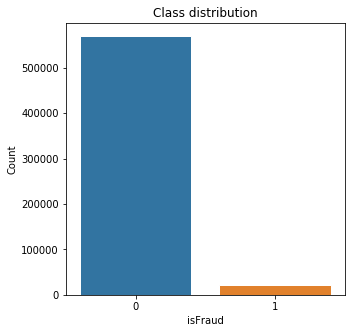

In [30]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)

sns.set_style('whitegrid')
sns.countplot(x='isFraud', data=df, ax=ax)
plt.title("Class distribution")
plt.ylabel("Count")     
plt.xlabel("isFraud")            

Let's look into data and see if we find any interesting patters. Categorical variables First!!

Let's treat the null values (for `object` type) let's fill it by `null` string. and visualize.

In [0]:
##Null treatment
df['DeviceType'].fillna(value='nan', inplace=True)

**Device type distribution**

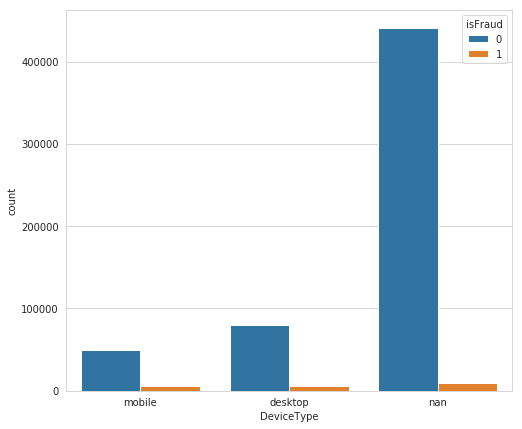

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(8, 7)
plt.ylabel("Count in K")     
g = sns.countplot(x=df['DeviceType'], hue=df['isFraud'], ax=ax)
plt.show()

* There seem to be a lot of desktop devices. 

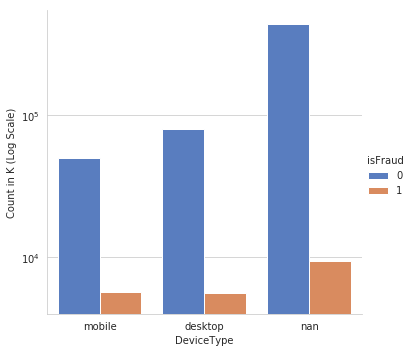

In [33]:
g = sns.factorplot(x="DeviceType", hue="isFraud", kind='count',
                   data=df, palette="muted", log=True)
plt.ylabel("Count in K (Log Scale)")  
g.fig.get_axes()[0].set_yscale('log')

**DeviceInfo distributions**

In [0]:
## Null values filled. 
df['DeviceInfo'].fillna(value='nan', inplace=True)
dev_info = df.DeviceInfo.value_counts()[0:10]

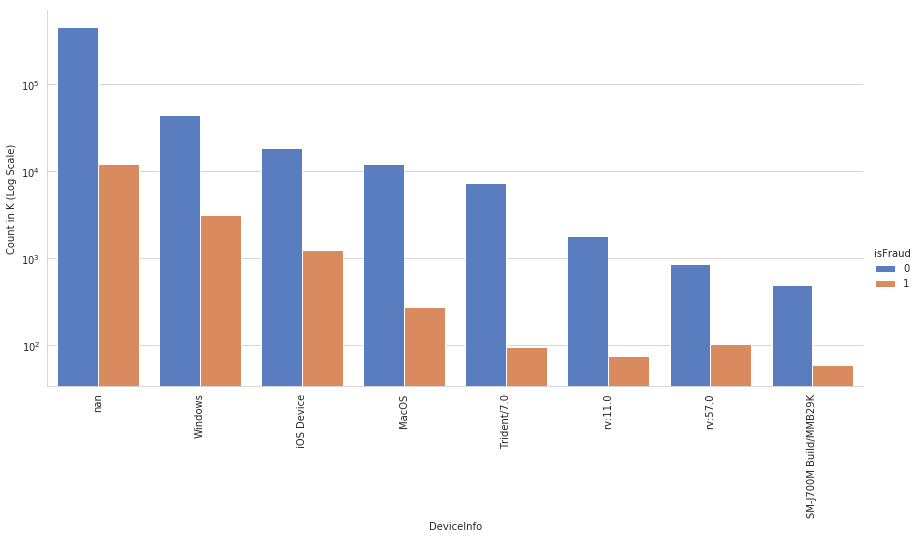

In [35]:
g = sns.factorplot(x="DeviceInfo", hue="isFraud", kind='count', orient='v',
                   data=df, palette="muted", log=True, order=df.DeviceInfo.value_counts().iloc[:8].index, size=6, aspect=2)

g.set_xticklabels(rotation=90)
plt.ylabel("Count in K (Log Scale)")  
g.fig.get_axes()[0].set_yscale('log')

**It is interesting to note that, for popular platforms, like windows and iOS, more that half of the transactions look fradulent.** After some interesting google searches, we find that names with SM- prefix are all samsung devices. So let's group them into one class. Additionall, Trident refers to IExplorer engine. There is a tough decison here as some specific devices version would be vulnerable to frauds while others may not. So, let's postpone our decision of clubbing devices together. Surprisingly, I couldn't find `Android` in top 20. Strange!!

In [36]:
display_all(df.DeviceInfo.value_counts().iloc[:20])

nan                            471874
Windows                         47722
iOS Device                      19782
MacOS                           12573
Trident/7.0                      7440
rv:11.0                          1901
rv:57.0                           962
SM-J700M Build/MMB29K             549
SM-G610M Build/MMB29K             461
SM-G531H Build/LMY48B             410
rv:59.0                           362
SM-G935F Build/NRD90M             334
SM-G955U Build/NRD90M             328
SM-G532M Build/MMB29T             316
ALE-L23 Build/HuaweiALE-L23       312
SM-G950U Build/NRD90M             290
SM-G930V Build/NRD90M             274
rv:58.0                           269
rv:52.0                           256
SAMSUNG                           235
Name: DeviceInfo, dtype: int64

**Transaction amounts**

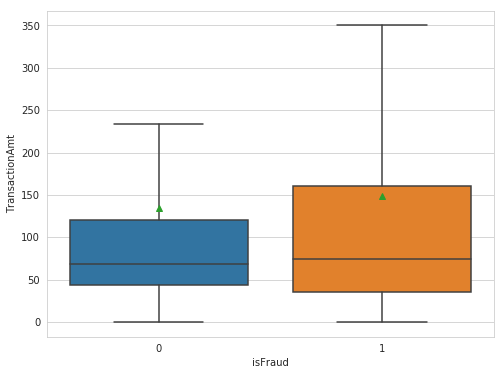

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sns.boxplot(y='TransactionAmt', x='isFraud', data=pd.DataFrame({'TransactionAmt':df['TransactionAmt'], 'isFraud':df['isFraud']}), ax=ax, showfliers=False, showmeans=True)

The above box plot is showing values without outliers. Therefore, we can see that the `IQR range` of `fradulent transactions` is `more` than that of the `legitimate transactions`. The `green triangles` show the mean of the legit and fradulent transactions.

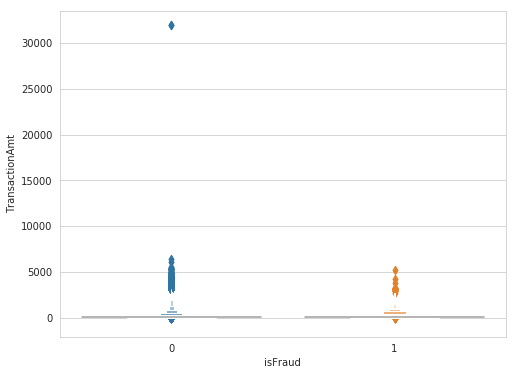

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sns.boxenplot(y='TransactionAmt', x='isFraud', data=pd.DataFrame({'TransactionAmt':df['TransactionAmt'], 'isFraud':df['isFraud']}), ax=ax)

From the above graph it is clear that, if the amount is very huge (above say 20K), it's highly likely that the transaction is not fraud or is legitimate. To visualize it properly, we use log scales. 

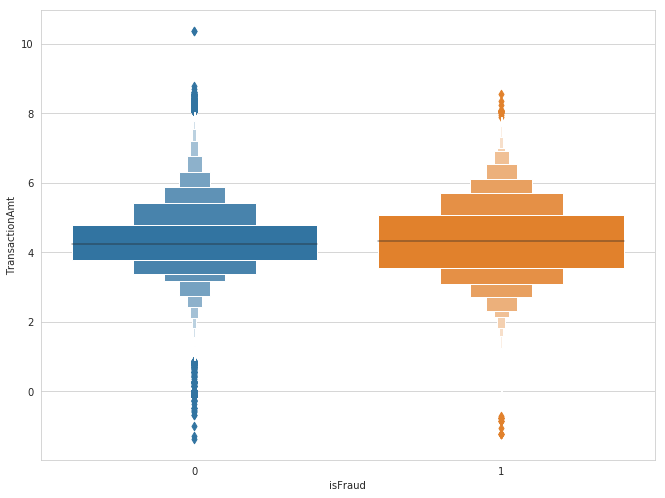

In [39]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.27)
sns.boxenplot(y='TransactionAmt', x='isFraud', data=pd.DataFrame({'TransactionAmt':np.log(df['TransactionAmt']), 'isFraud':df['isFraud']}), ax=ax)

**From the above plot it is clear that the fraud transactions have a wider range from 1st quartile to 3rd quartile. There are a lot of outliers in the legitimate transactions.**

# Answer to [Q3]

**Product CD**

Please read the comments below the graphs in order to note the observations.

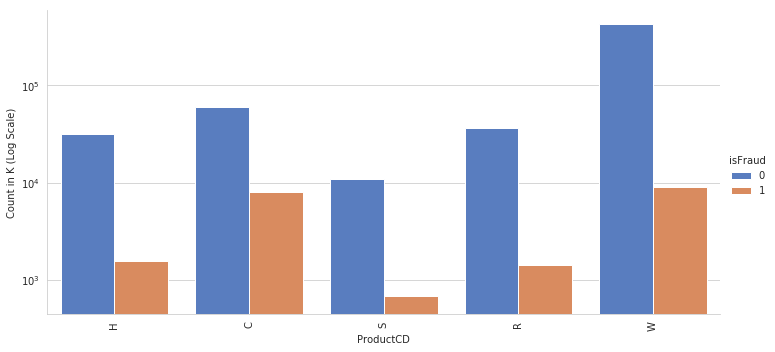

In [49]:
g = sns.factorplot(x="ProductCD", hue="isFraud", kind='count', orient='v',
                   data=df, palette="muted", log=True,  size=5, aspect=2)

g.set_xticklabels(rotation=90)
plt.ylabel("Count in K (Log Scale)")  
g.fig.get_axes()[0].set_yscale('log')

Prima facia, from the above plot it appears that products with `ProductCD = S` and `R` are expensive products as they are low in numbers. Also, premium products like high range smart phones and devices have additional technologies like NFCs etc. for fraud protections. Nevertheless, let's match this information with the info in column `DeciceType`, `DeviceInfo` and `TransactionAmt` and see what we unviel.

**Product CD vs. Transaction Amount**

Text(23.56884982638889, 0.5, 'Transaction Amount')

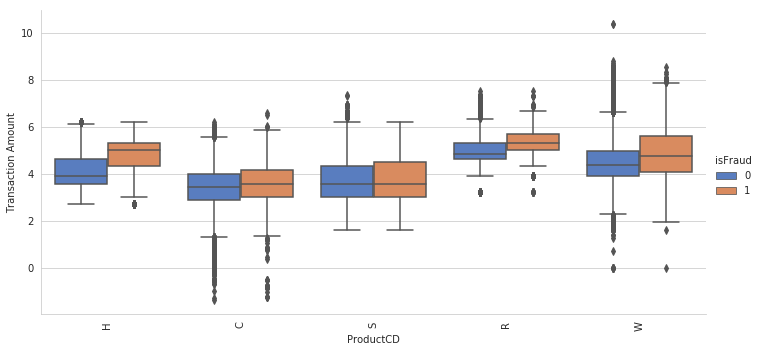

In [50]:
g = sns.factorplot(x="ProductCD", y='TransactionAmt' ,hue="isFraud", kind='box', orient='v',
                   data=pd.DataFrame({'TransactionAmt':np.log(df['TransactionAmt']), 'isFraud':df['isFraud'], 'ProductCD': df['ProductCD']}), palette="muted",   size=5, aspect=2)

g.set_xticklabels(rotation=90)
plt.ylabel("Transaction Amount")

**From the above plot it is clear that, product category `R` has relatively higher transaction amounts in percentiles. So, premium product users are likely to transact on higher amounts. This is also true for category `H`**

> Let's check device info for the different Product CDs

In [0]:
#data = df.groupby(['ProductCD', 'DeviceInfo', 'isFraud']).sum()
#print (data.shape)

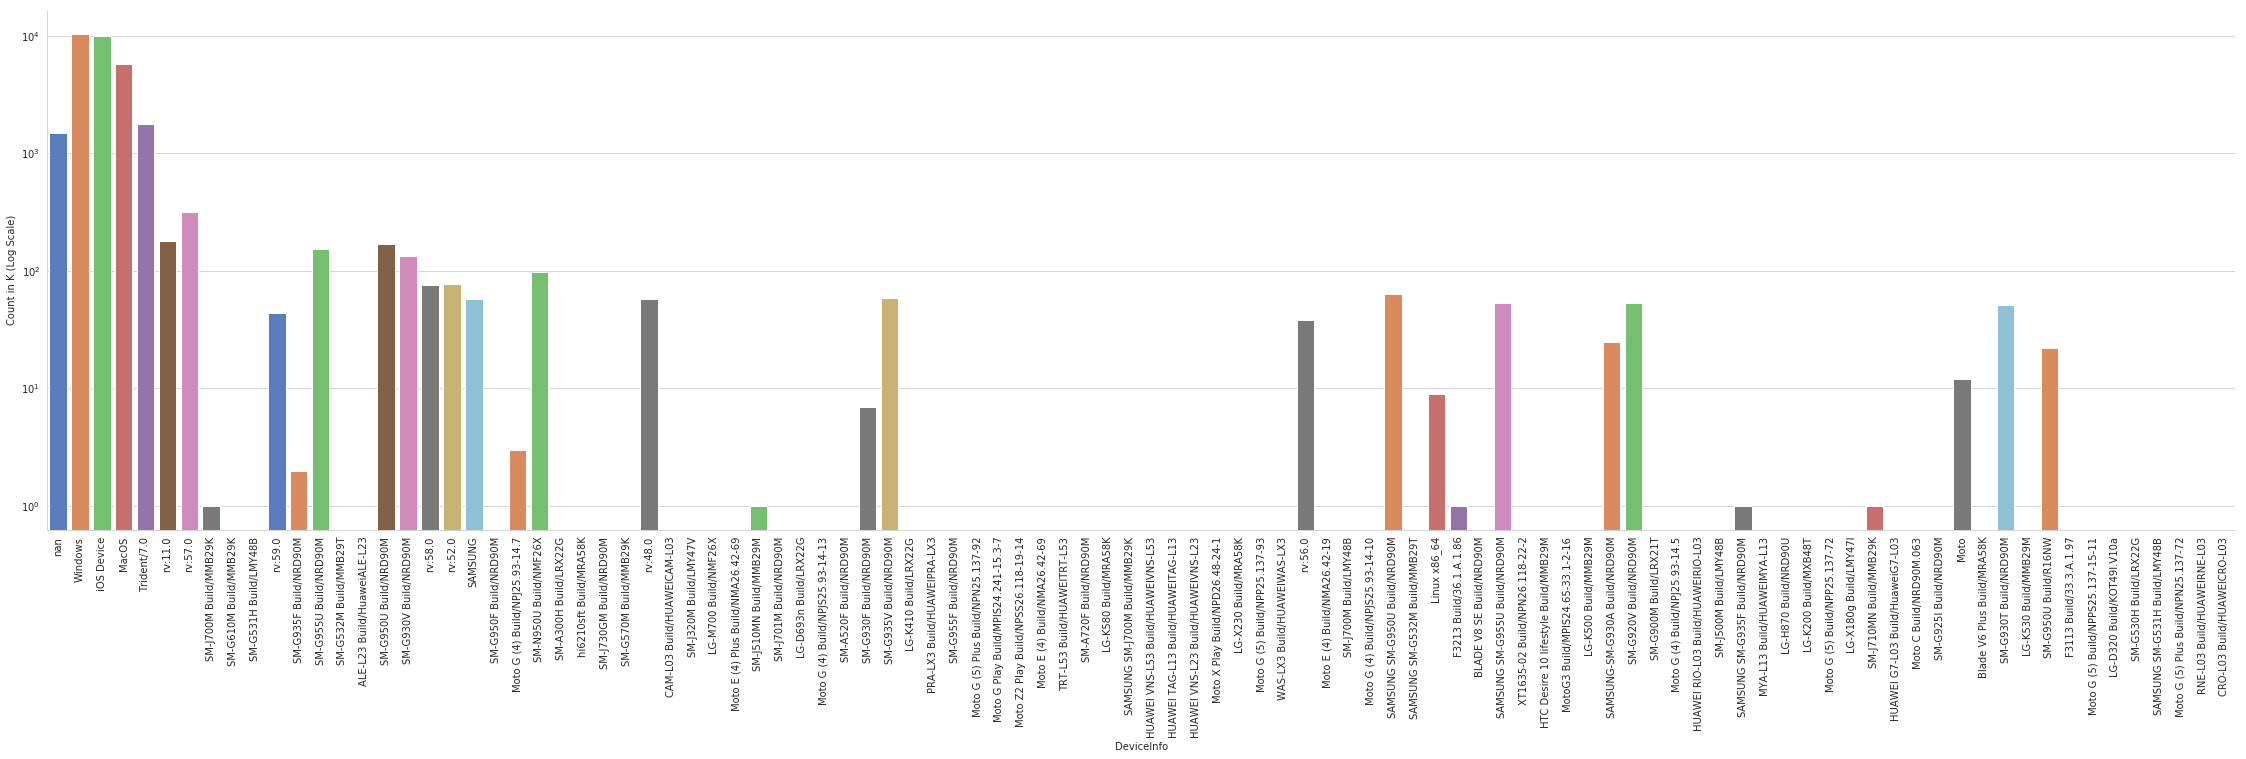

In [52]:
g = sns.factorplot(x="DeviceInfo",  kind='count', orient='h',
                   data=df.loc[df.ProductCD=='H'], palette="muted", log=True, order=df.DeviceInfo.value_counts().iloc[:100].sort_values(ascending=False).index, size=8, aspect=4)

g.set_xticklabels(rotation=90)
plt.ylabel("Count in K (Log Scale)")  
g.fig.get_axes()[0].set_yscale('log')

**Observations**

1.   Most of the devices don't share their information
2.   Windows appears to be the most frequently used platform (Some machines like business laptops ThinkPads, Latitudes etc. could be into the premium products category)
3.   It is followed by iOS devices which are IPhones who are expensive.
4.   Then come the MacOS these devices are also expensive.



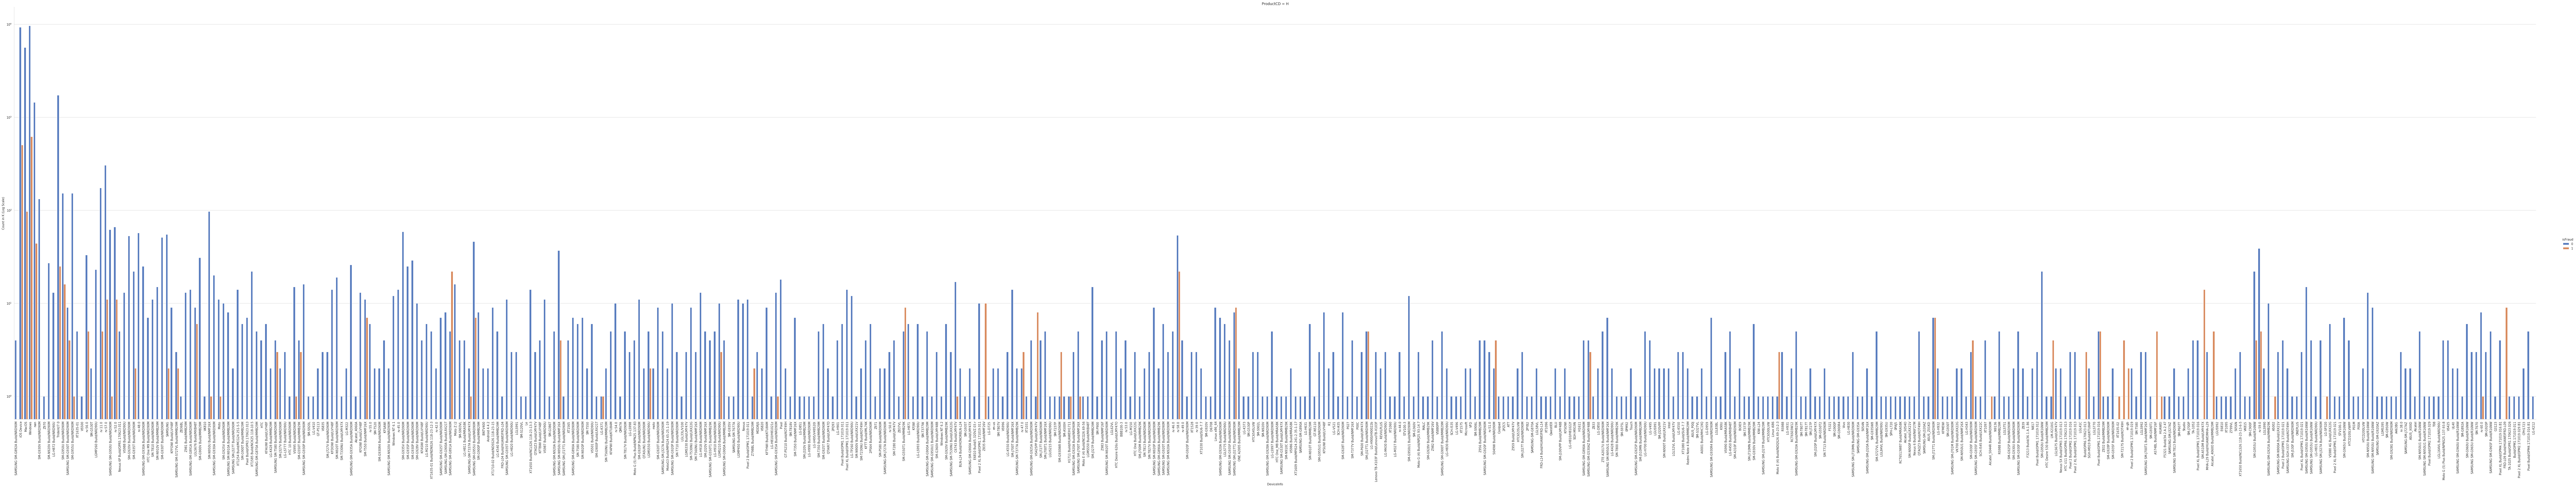

In [53]:
g = sns.factorplot(x="DeviceInfo", hue="isFraud", kind='count', orient='h',
                  data=df.loc[df.ProductCD=='H'], palette="muted", log=True,  size=20, aspect=6)

g.set_xticklabels(rotation=90)
plt.ylabel("Count in K (Log Scale)")  
g.fig.get_axes()[0].set_yscale('log')
plt.title('ProductCD = H')
plt.show()

**Links to some of the top models**

https://www.samsung.com/us/business/support/owners/product/galaxy-s8-active-at-t/       The top frequent device...
  
Z970 is a mid range phone  
https://www.google.com/search?client=firefox-b-1-d&q=smg930v

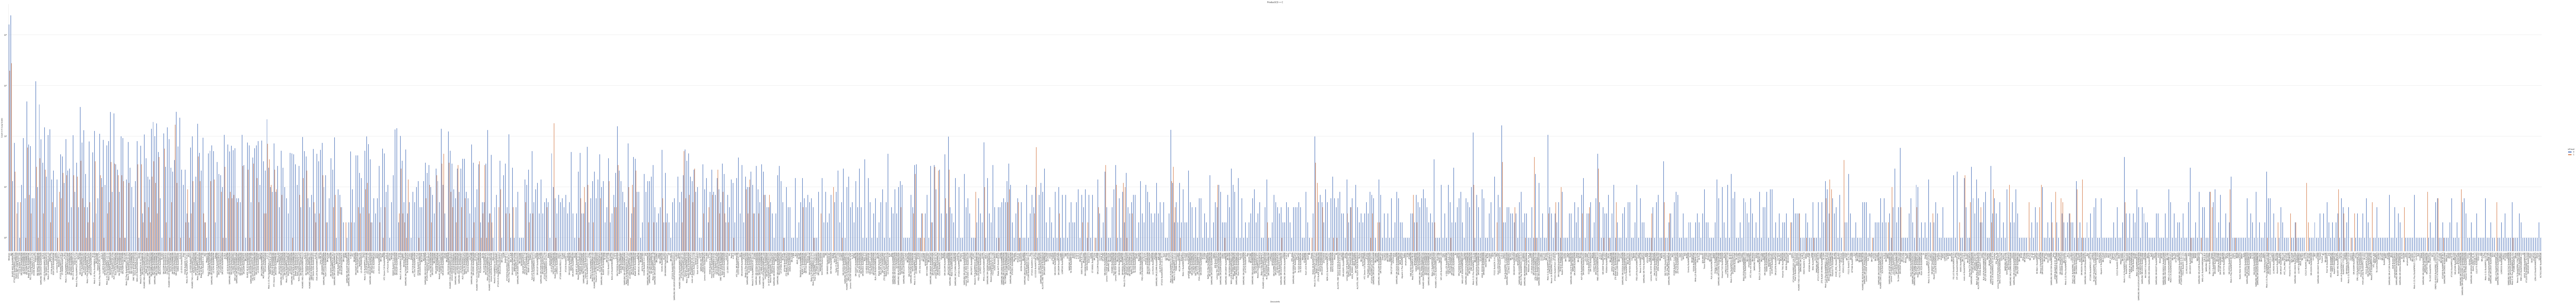

In [54]:
g = sns.factorplot(x="DeviceInfo", hue="isFraud", kind='count', orient='h',
                  data=df.loc[df.ProductCD=="C"], palette="muted", log=True,  size=20, aspect=10)

g.set_xticklabels(rotation=90)
plt.ylabel("Count in K (Log Scale)")  
g.fig.get_axes()[0].set_yscale('log')
plt.title('ProductCD = C')
plt.show()

**C is a category of cheap devices (I can spot more low range models like Redmi Note 4, Moto G) etc.**

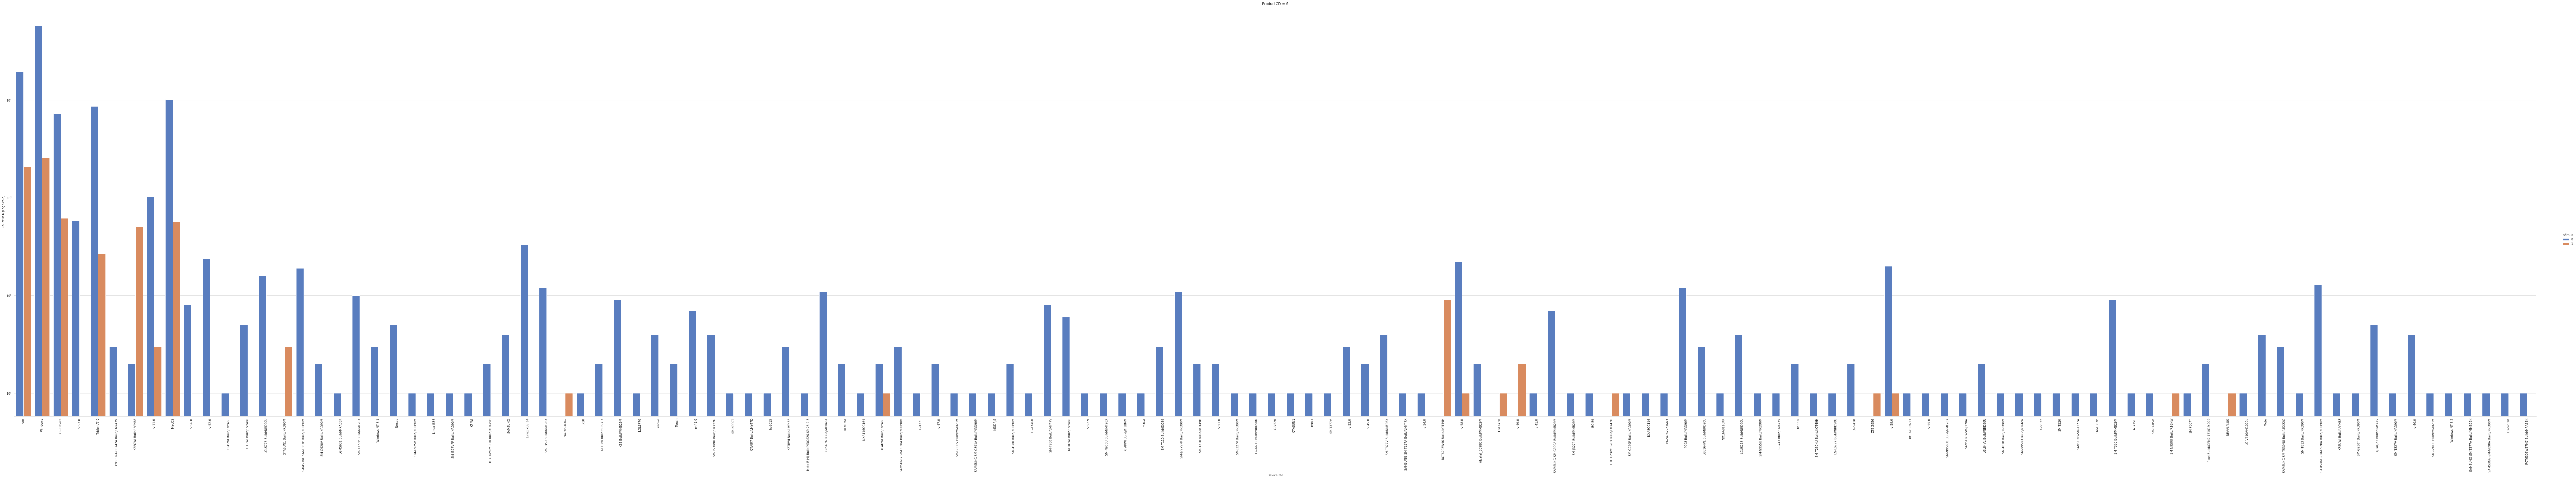

In [55]:
g = sns.factorplot(x="DeviceInfo", hue="isFraud", kind='count', orient='h',
                  data=df.loc[df.ProductCD=="S"], palette="muted", log=True,  size=20, aspect=6)

g.set_xticklabels(rotation=90)
plt.ylabel("Count in K (Log Scale)")  
g.fig.get_axes()[0].set_yscale('log')
plt.title('ProductCD = S')
plt.show()

**S class usually denotes, desktop/laptop devices as the information that we have is mostly of the browser build version and User agents**

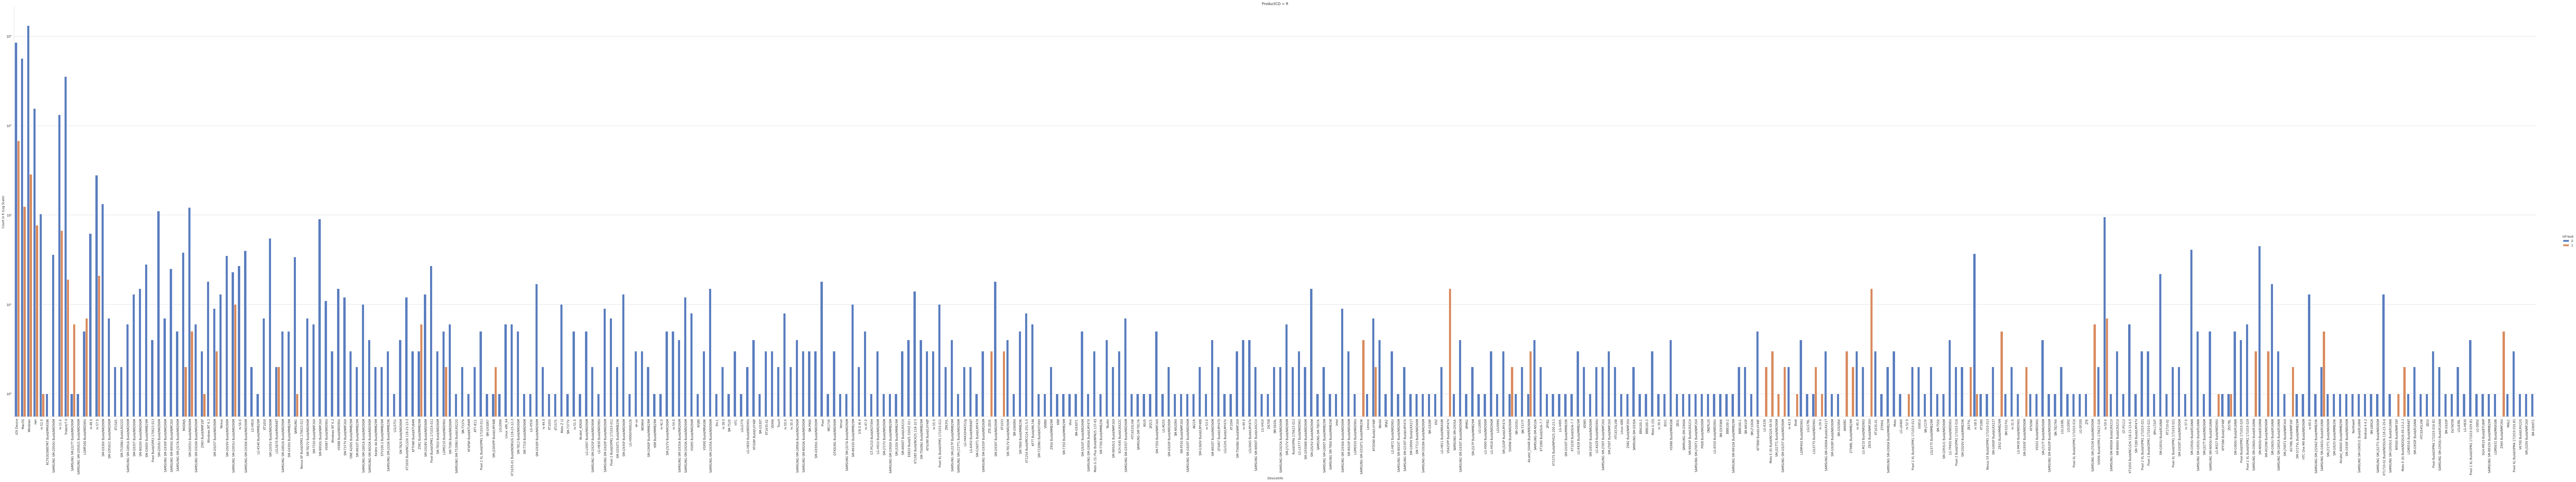

In [56]:
g = sns.factorplot(x="DeviceInfo", hue="isFraud", kind='count', orient='h',
                  data=df.loc[df.ProductCD=="R"], palette="muted", log=True,  size=20, aspect=6)

g.set_xticklabels(rotation=90)
plt.ylabel("Count in K (Log Scale)")  
g.fig.get_axes()[0].set_yscale('log')
plt.title('ProductCD = R')
plt.show()

**This could probably be the category of premium devices.** . 

Samsung S8 spotted SM-G950U   

https://www.google.com/search?client=firefox-b-1-d&sxsrf=ACYBGNS0knMmqQIuf_-jhzd3dvCuYdRjCA%3A1568949938379&ei=skaEXb3fFqW6ggfI0rH4Dw&q=sm+g950u&oq=sm+g950u&gs_l=psy-ab.3..0l10.11768.15603..15898...1.4..0.84.639.9....2..0....1..gws-wiz.......0i71j35i39j0i131.sRHo_tcTlf4&ved=0ahUKEwi9gP39ud7kAhUlneAKHUhpDP8Q4dUDCAo&uact=5

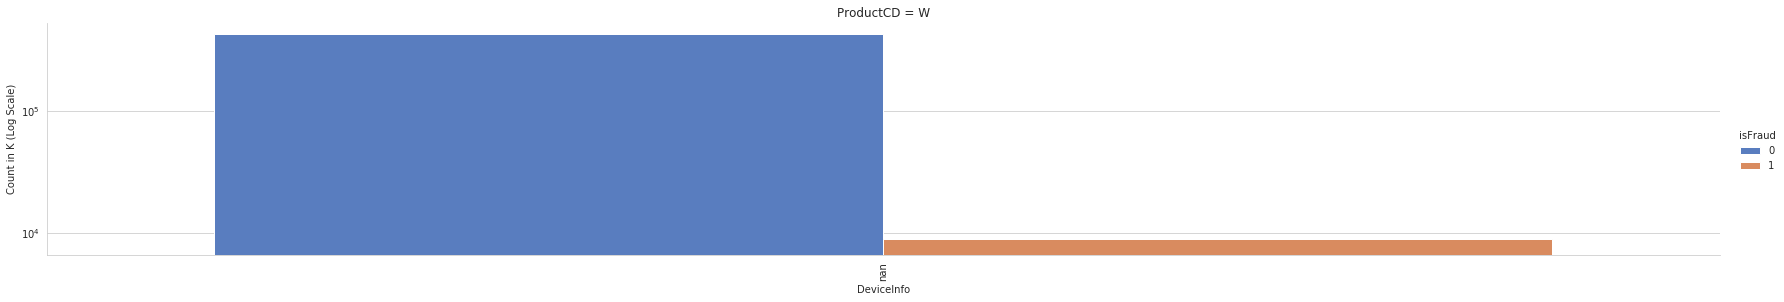

In [57]:
g = sns.factorplot(x="DeviceInfo", hue="isFraud", kind='count', orient='h',
                  data=df.loc[df.ProductCD=="W"], palette="muted", log=True,  size=4, aspect=6)

g.set_xticklabels(rotation=90)
plt.ylabel("Count in K (Log Scale)")  
g.fig.get_axes()[0].set_yscale('log')
plt.title('ProductCD = W')
plt.show()

So, there is no device Info Available for ProductCD = 'W' In the train data set.

# Visualizations and EDA (contd.) [Q1]

In [0]:
df['card4'].fillna(value='nan', inplace=True)

(5,)


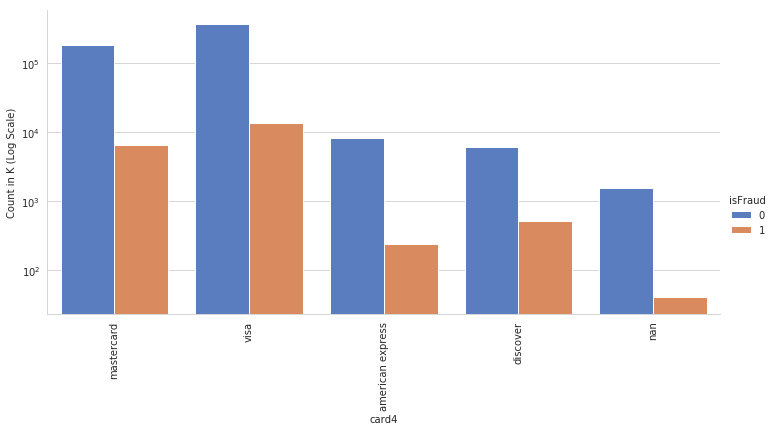

In [59]:
print (df.card4.unique().shape)

g = sns.factorplot(x="card4", hue="isFraud", kind='count', orient='v',
                   data=df, palette="muted", log=True,  size=5, aspect=2)

g.set_xticklabels(rotation=90)
plt.ylabel("Count in K (Log Scale)")  
g.fig.get_axes()[0].set_yscale('log')

Looks like `american experess` is a pro when it comes to preventing fradulent transactions. They have relatively lower rate as compared to others. It is followed by `discover`. We have replaced .26 percent of missing values as `na`

In [0]:
df['card6'].fillna(value='nan', inplace=True)

(5,)


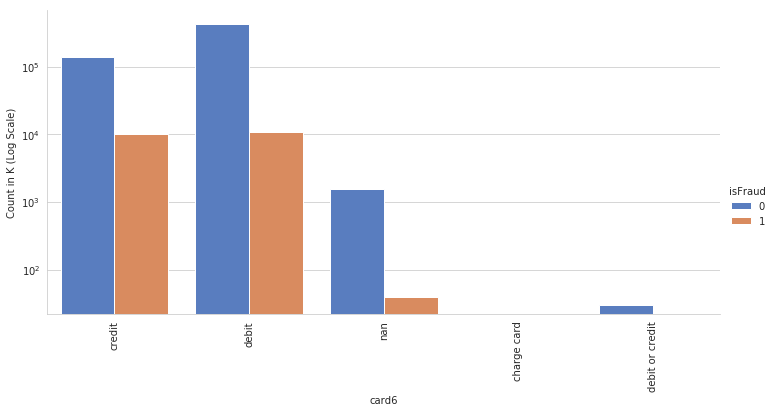

In [61]:
print (df['card6'].unique().shape)

g = sns.factorplot(x="card6", hue="isFraud", kind='count', orient='v',
                   data=df, palette="muted", log=True,  size=5, aspect=2)

g.set_xticklabels(rotation=90)
plt.ylabel("Count in K (Log Scale)")  
g.fig.get_axes()[0].set_yscale('log')

In [0]:
df['P_emaildomain'].fillna(value='nan', inplace=True)

In [63]:
print (df.P_emaildomain.unique().shape)
display_all(df.P_emaildomain.value_counts())

(60,)


gmail.com           228355
yahoo.com           100934
nan                  94456
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
roadrunner.com         305
windstream.net         305
hotmail.es             305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
t

(60,)


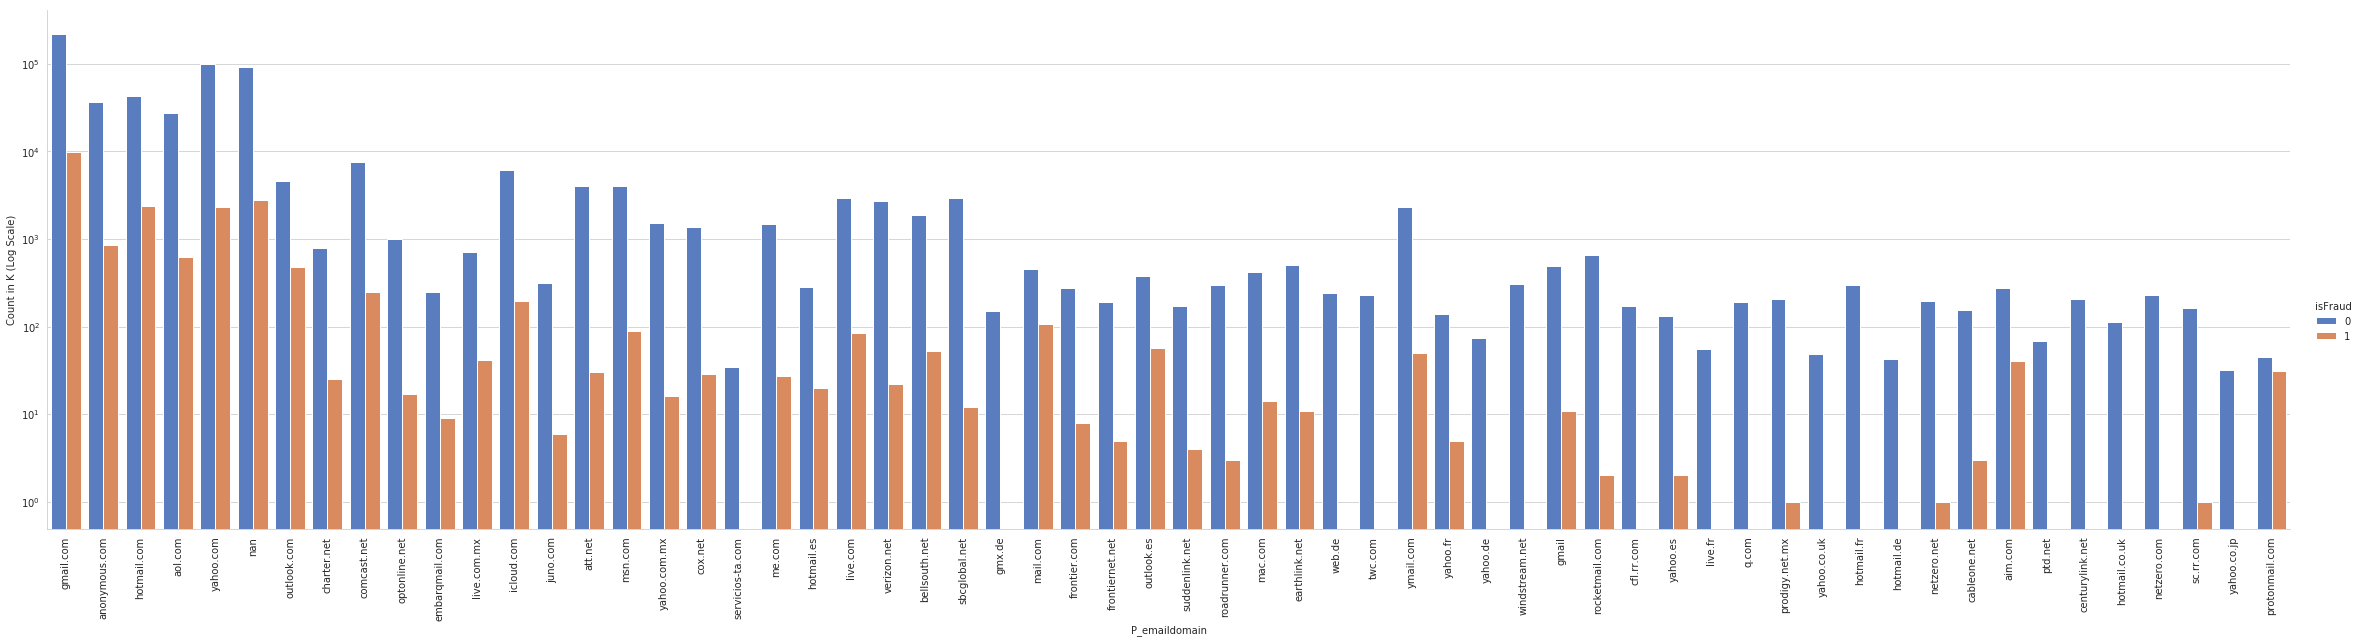

In [64]:
print (df['P_emaildomain'].unique().shape)

g = sns.factorplot(x="P_emaildomain", hue="isFraud", kind='count', orient='v',
                   data=df, palette="muted", log=True,  size=8, aspect=4)

g.set_xticklabels(rotation=90)
plt.ylabel("Count in K (Log Scale)")  
g.fig.get_axes()[0].set_yscale('log')

**Interestingly, from the above plot we can see that, for emails from some domains, there are almost no fradulent transactions. So, it would make a great attribute for classification**

**R_emaildomain**

In [0]:
df['R_emaildomain'].fillna(value='nan', inplace=True)

In [66]:
print (df.R_emaildomain.unique().shape)
display_all(df.R_emaildomain.value_counts())

(61,)


nan                 453249
gmail.com            57147
hotmail.com          27509
anonymous.com        20529
yahoo.com            11842
aol.com               3701
outlook.com           2507
comcast.net           1812
yahoo.com.mx          1508
icloud.com            1398
msn.com                852
live.com               762
live.com.mx            754
verizon.net            620
me.com                 556
sbcglobal.net          552
cox.net                459
outlook.es             433
att.net                430
bellsouth.net          422
hotmail.fr             293
hotmail.es             292
web.de                 237
mac.com                218
ymail.com              207
prodigy.net.mx         207
optonline.net          187
gmx.de                 147
yahoo.fr               137
charter.net            127
mail.com               122
hotmail.co.uk          105
gmail                   95
earthlink.net           79
yahoo.de                75
rocketmail.com          69
embarqmail.com          68
s

(61,)


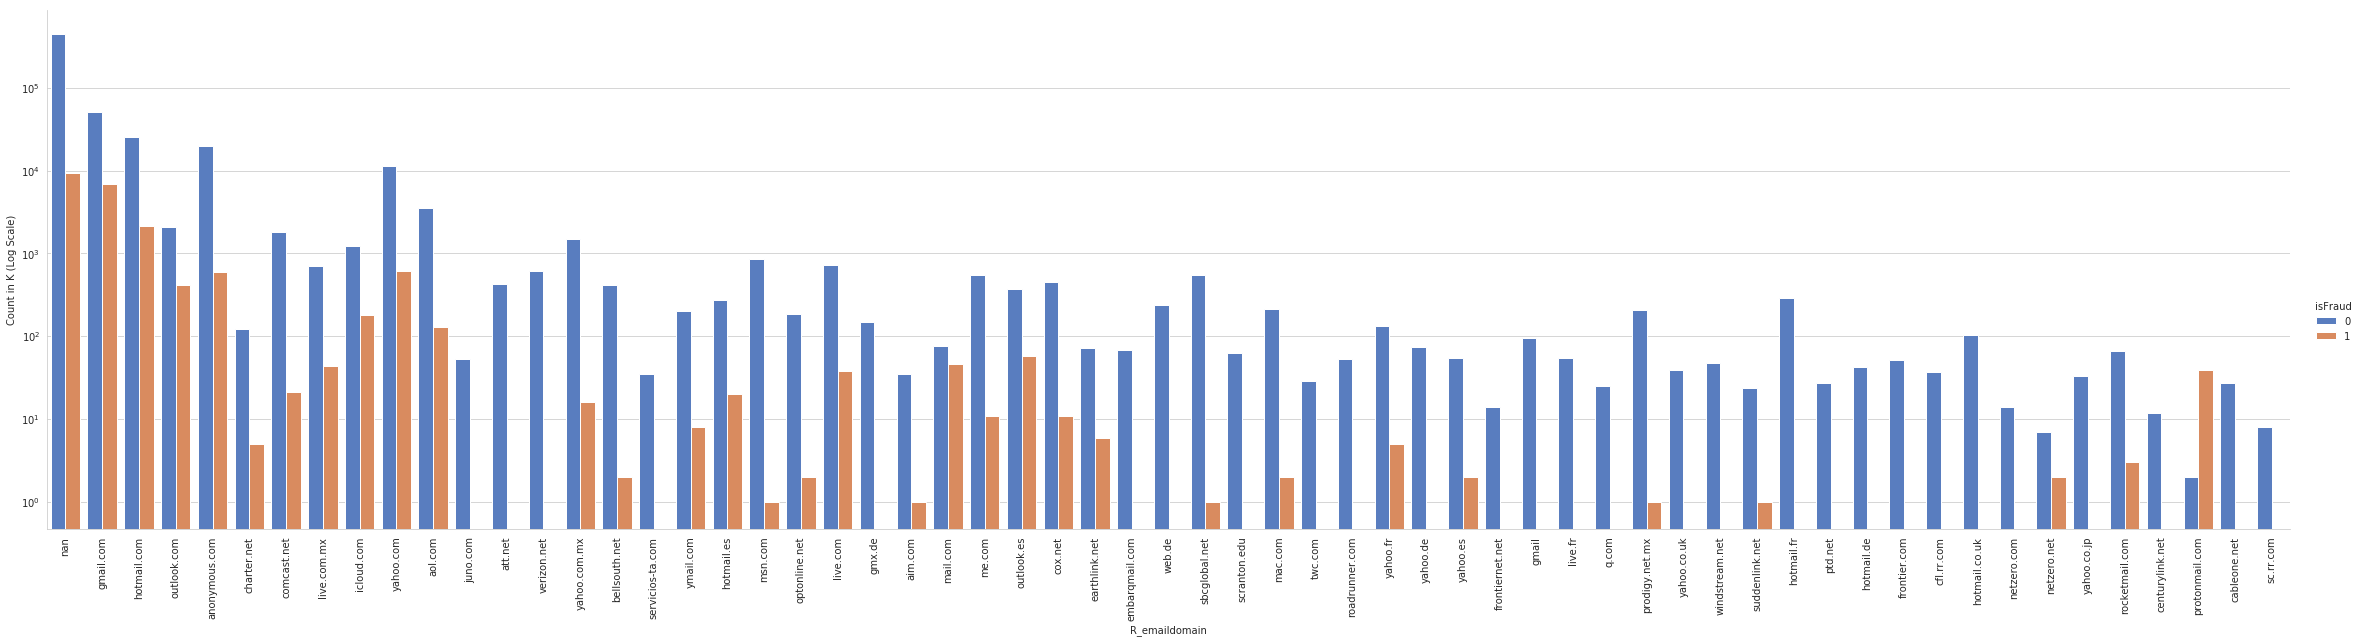

In [67]:
print (df['R_emaildomain'].unique().shape)

g = sns.factorplot(x="R_emaildomain", hue="isFraud", kind='count', orient='v',
                   data=df, palette="muted", log=True,  size=8, aspect=4)

g.set_xticklabels(rotation=90)
plt.ylabel("Count in K (Log Scale)")  
g.fig.get_axes()[0].set_yscale('log')

**One probable reason for huge no of NAs in this field could be that, the receivers could have been getting money, just based on a/c no. as email, might not be mandated.**

**addr1**    
This looks like a categorical variable, so let's convert it to a string variable. 

In [68]:
df['addr1'] = df.addr1.astype('str')
df['addr1'].fillna(value='nan', inplace=True)
print (df.addr1.unique().shape)
print (df.addr1.value_counts().head(20))

(333,)
nan      65706
299.0    46335
325.0    42751
204.0    42020
264.0    39870
330.0    26287
315.0    23078
441.0    20827
272.0    20141
123.0    16105
126.0    15243
184.0    15160
337.0    15149
191.0    14979
181.0    13856
143.0     9806
476.0     9478
310.0     8486
472.0     8478
327.0     8425
Name: addr1, dtype: int64


Let's plot top countries with fradulent transactions

In [0]:
# Group by operation trial
temp = df.groupby(['addr1','isFraud']).size()
temp = temp.unstack()
temp.fillna(value=0, inplace=True)

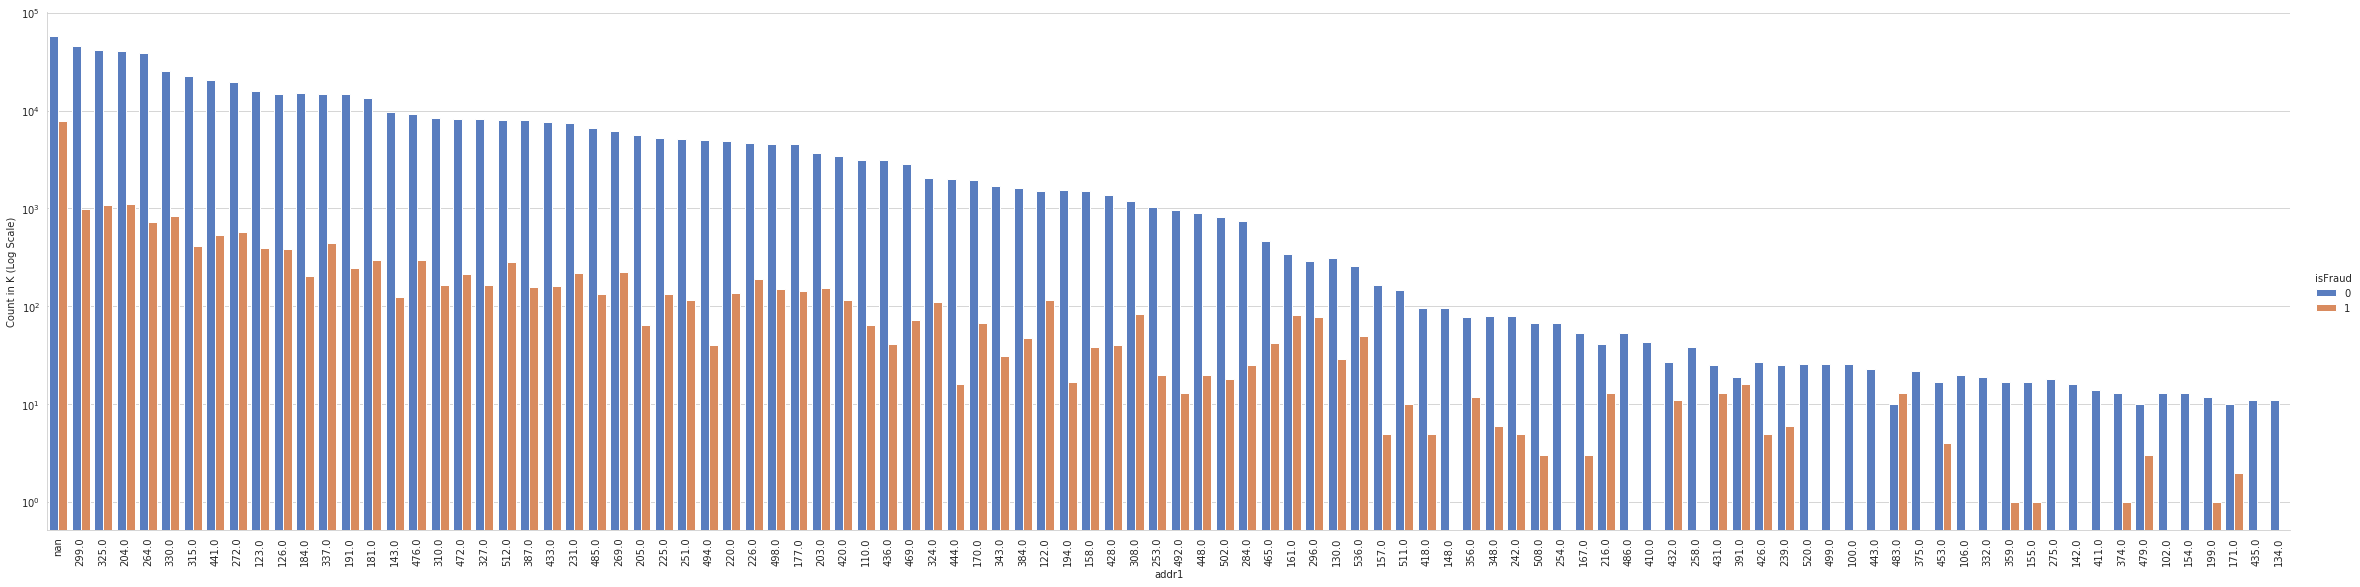

In [70]:
g = sns.factorplot(x="addr1", hue="isFraud", kind='count', orient='v',
                   data=df, palette="muted", log=True, order=df.addr1.value_counts().iloc[:100].index, size=8, aspect=4)

g.set_xticklabels(rotation=90)
plt.ylabel("Count in K (Log Scale)")  
g.fig.get_axes()[0].set_yscale('log')

From the above graph, we can see that some `addr1` locations have a lower rate of fradulent transactions that others. Eg. `410.0`, `486.0` have a lower chance as compared to other addresses with comparable legit transactions, like `384`, `282`

In [71]:
df['addr2'] = df.addr2.astype('str')
df['addr2'].fillna(value='nan', inplace=True)
print (df.addr2.unique().shape)
print (df.addr2.value_counts().head(20))

(75,)
87.0     520481
nan       65706
60.0       3084
96.0        638
32.0         91
65.0         82
16.0         55
31.0         47
19.0         33
26.0         25
27.0         20
59.0         17
69.0         17
34.0         16
43.0         12
98.0         11
29.0         11
102.0        11
57.0         10
68.0         10
Name: addr2, dtype: int64


# Most frequent country code analysis [addr2] [Q]

Text(0.5, 1.0, 'The distribution of addr2 against isFraud variable')

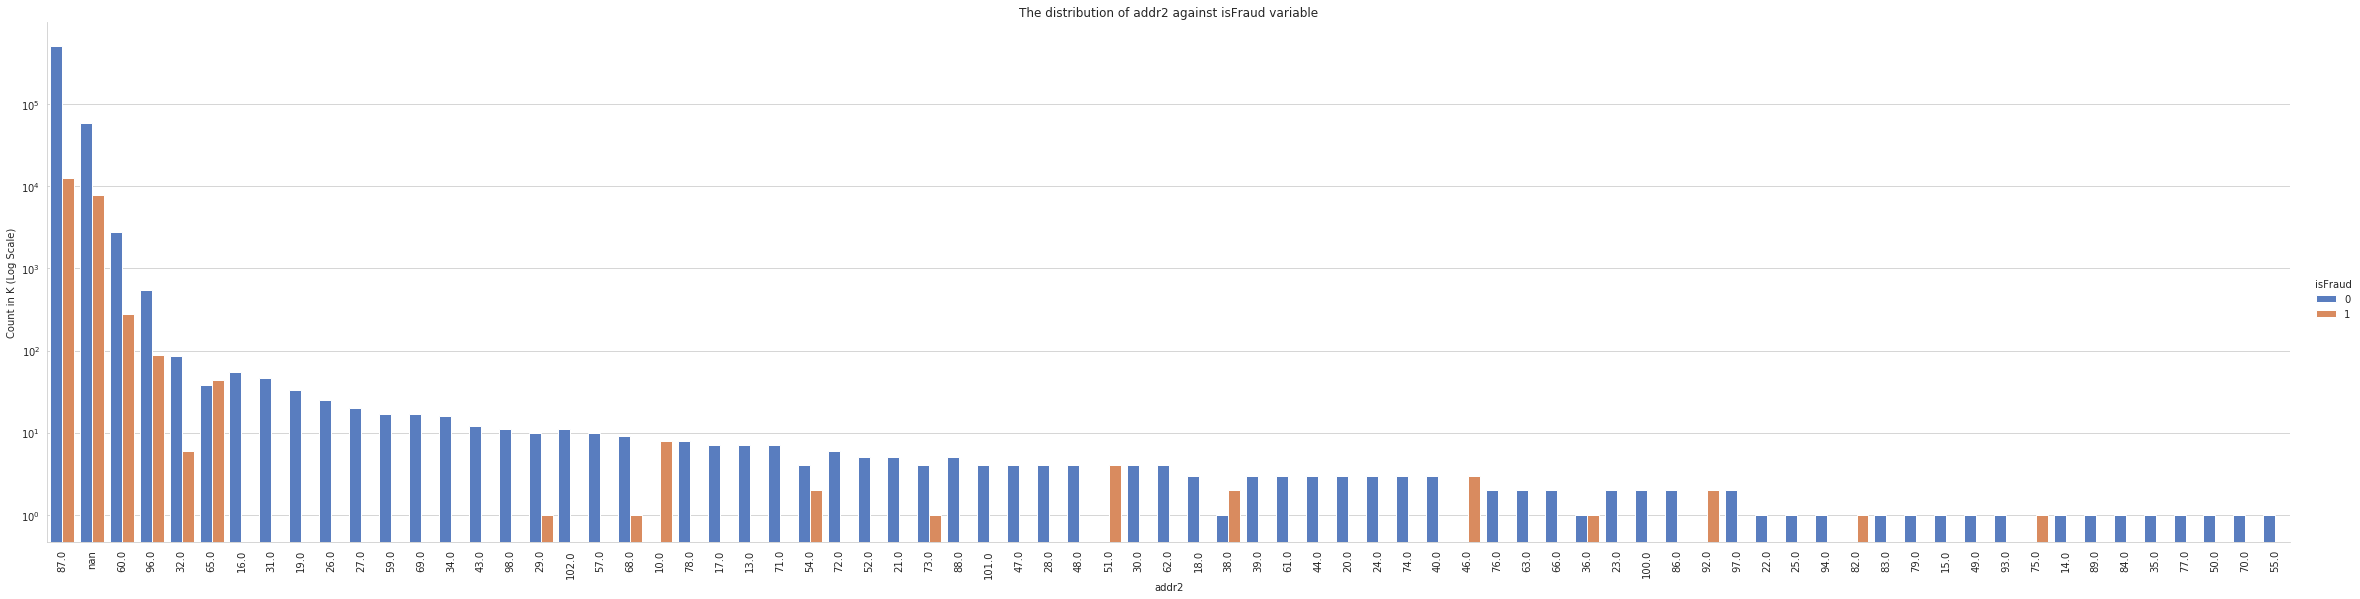

In [77]:
g = sns.factorplot(x="addr2", hue="isFraud", kind='count', orient='v',
                   data=df, palette="muted", log=True, order=df.addr2.value_counts().iloc[:75].index, size=8, aspect=4)

g.set_xticklabels(rotation=90)
plt.ylabel("Count in K (Log Scale)")  
g.fig.get_axes()[0].set_yscale('log')
plt.title('The distribution of addr2 against isFraud variable')

This graph looks more clearer that the previous one, as many addresses look to have legit transactions and almost no fraud transactions. Some address like `51.0`, `46.0`, `92.0` have only fraudulent transactions, it appears.

In [0]:
mean_amt = df[['addr2', 'TransactionAmt', 'isFraud']].groupby('addr2').mean()
max_amt = df[['addr2', 'TransactionAmt']].groupby('addr2').max()
min_amt = df[['addr2', 'TransactionAmt']].groupby('addr2').min()

In [116]:
temp = df.addr2.value_counts()[:10].index
subset = df[df['addr2'].isin(temp)]
subset['addr2'].value_counts()

87.0    520481
nan      65706
60.0      3084
96.0       638
32.0        91
65.0        82
16.0        55
31.0        47
19.0        33
26.0        25
Name: addr2, dtype: int64

# Magnify the most frequent addr2s used
**Trying to analyse the relationship between TransactionAmt and Fraud transactions for top 10 addr2 values**

Text(0.5, 1.0, 'Legitimate transactions, without outliers')

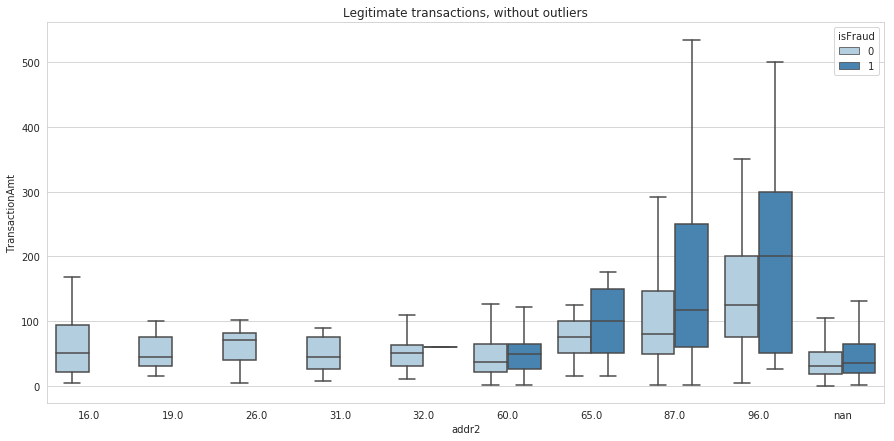

In [117]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 7)

g = sns.boxplot(x="addr2", y='TransactionAmt', hue='isFraud',
                   data=subset,   palette="Blues", showfliers=False)

plt.title("Legitimate transactions, without outliers")

From the above plot for the top 10 frequently occurring `addr2` values, we see that some `addr2` have fraud transactions and their amounts have a lot of variance for `87.0` and `96.0` while some `addr2` values have none!!

**dist1**    
Even dist1/dist2 appear to be categorical variables. So, let us convert them to strings instead.

In [118]:
df['dist1'] = df.dist1.astype('str')
df['dist1'].fillna(value='nan', inplace=True)
print (df.dist1.unique().shape)
print (df.dist1.value_counts().head(20))

(2413,)
nan     352271
0.0      19824
1.0      18330
2.0      17028
4.0      13067
3.0      12808
5.0      12004
6.0       9843
7.0       9340
8.0       7731
9.0       7728
10.0      6288
11.0      6047
12.0      5384
14.0      4603
13.0      4559
15.0      3451
16.0      3390
18.0      2818
17.0      2766
Name: dist1, dtype: int64


Text(0.5, 1.0, 'The distribution of dist1 against isFraud variable')

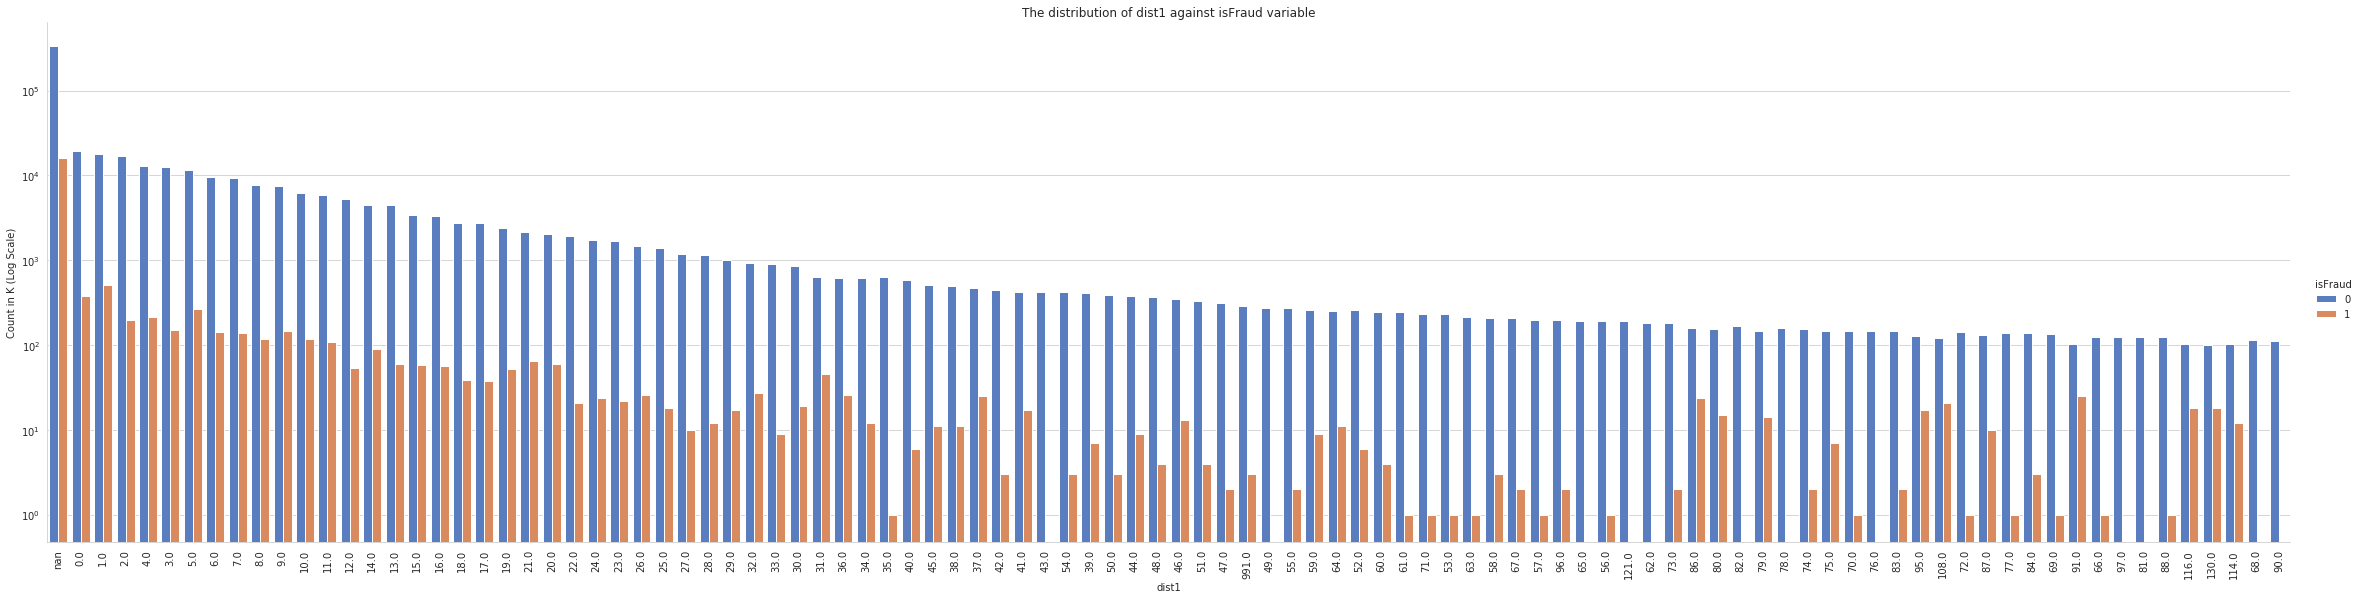

In [119]:
g = sns.factorplot(x="dist1", hue="isFraud", kind='count', orient='v',
                   data=df, palette="muted", log=True, order=df.dist1.value_counts().iloc[:100].index, size=8, aspect=4)

g.set_xticklabels(rotation=90)
plt.ylabel("Count in K (Log Scale)")  
g.fig.get_axes()[0].set_yscale('log')
plt.title('The distribution of dist1 against isFraud variable')

In [120]:
df['dist2'] = df.dist2.astype('str')
df['dist2'].fillna(value='nan', inplace=True)
print (df.dist2.unique().shape)
print (df.dist2.value_counts().head(20))

(1700,)
nan      552913
7.0        5687
0.0        3519
1.0        1374
9.0         742
4.0         659
2.0         556
3.0         490
68.0        485
6.0         412
13.0        397
199.0       362
10.0        356
149.0       286
30.0        279
15.0        269
5.0         262
17.0        257
14.0        254
23.0        234
Name: dist2, dtype: int64


Text(0.5, 1.0, 'The distribution of dist2 against isFraud variable')

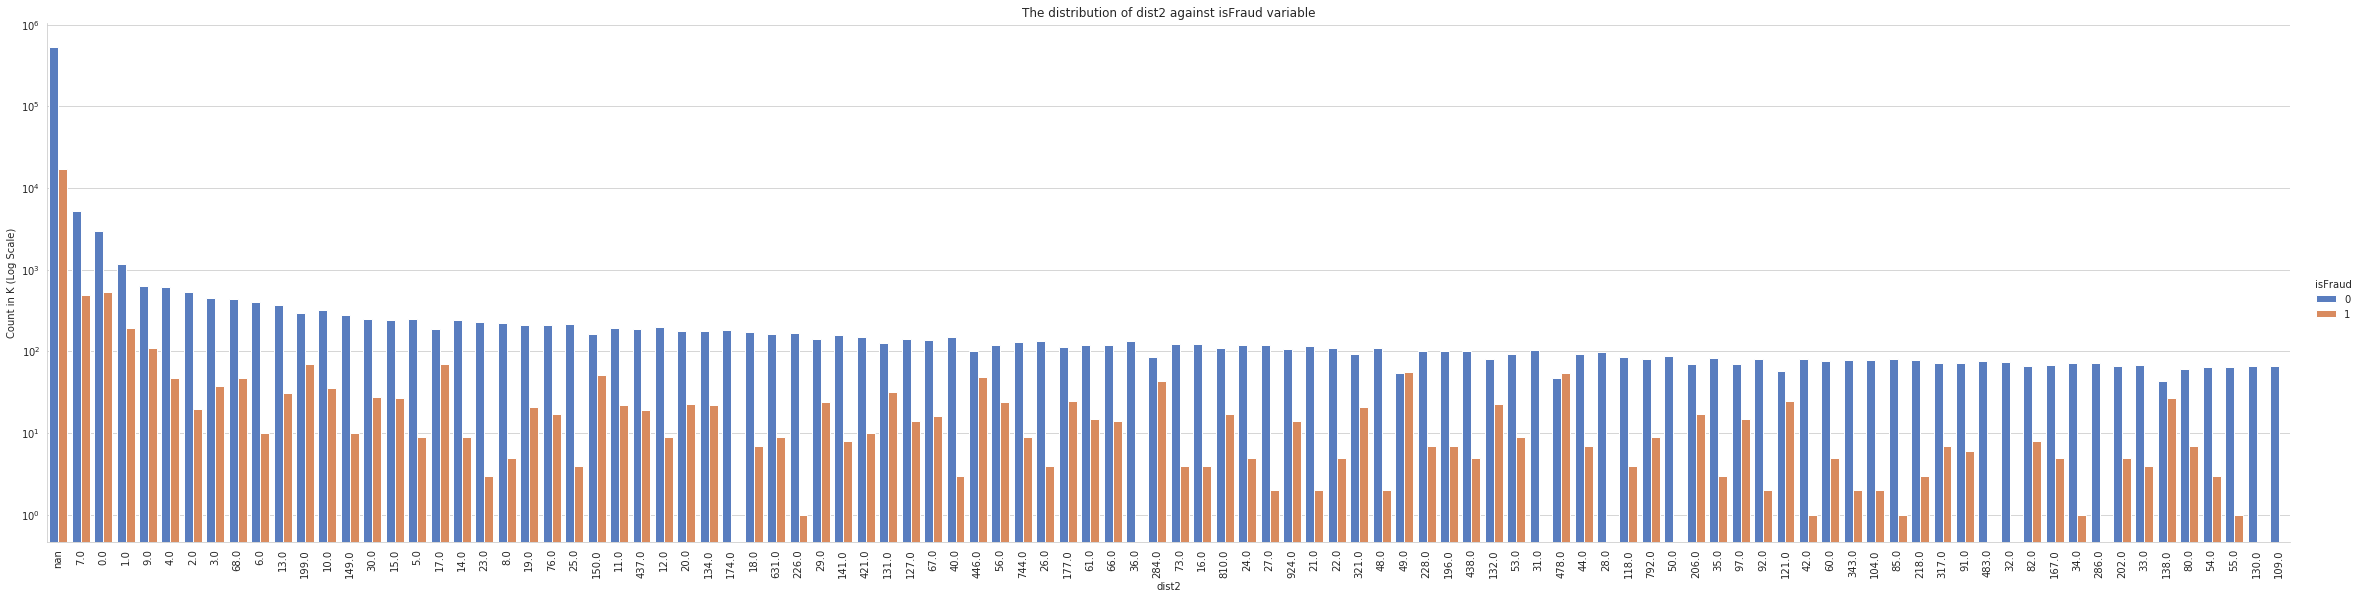

In [121]:
g = sns.factorplot(x="dist2", hue="isFraud", kind='count', orient='v',
                   data=df, palette="muted", log=True, order=df.dist2.value_counts().iloc[:100].index, size=8, aspect=4)

g.set_xticklabels(rotation=90)
plt.ylabel("Count in K (Log Scale)")  
g.fig.get_axes()[0].set_yscale('log')
plt.title('The distribution of dist2 against isFraud variable')

Similar observations can be drawn for distributions of `dist1` and `dist2` graphs. Some, values do not have any fradulent transactions. (But this may not be the same case in the test data)

# Dealing with transaction time.   [Q]
Extract more features from transaction time

The training data appears to be of 183 days, so if we zoom in, we can see the periodicity of transactions. 

#   Time of day and purchase amount [Q]

In [0]:
def get_hour_of_day(col):
  temp = col / (3600)
  temp = np.floor(temp) % 24
  return temp

In [0]:
temp = get_hour_of_day(df.TransactionDT)
df['hour_of_day'] = temp

In [124]:
df.groupby('hour_of_day').mean().head()['isFraud']

hour_of_day
0.0    0.031380
1.0    0.031314
2.0    0.037483
3.0    0.038314
4.0    0.051890
Name: isFraud, dtype: float64

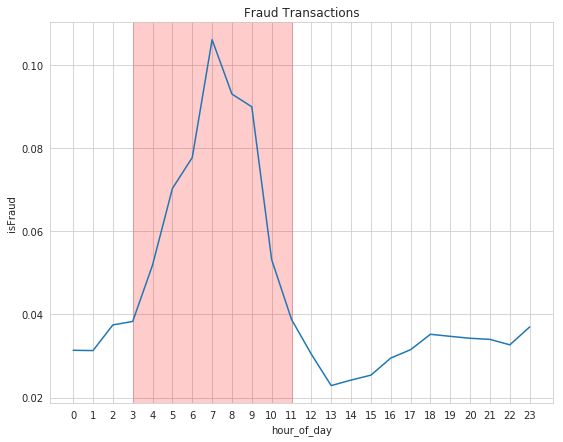

In [125]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 7)

sns.lineplot(x=df.groupby('hour_of_day').mean()['isFraud'].index, y=df.groupby('hour_of_day').mean()['isFraud'])
plt.title('Fraud Transactions')
plt.xticks(np.arange(0,24))
plt.axvspan(3, 11, color='red', alpha=0.2)
plt.show()

As the portion highlighted above, the rate of fraud transactions, spikes more between 3 am - 11 am

In [0]:
def filter(x):
  if (x == 0) :
    return 1
  return 0

In [0]:
hour_of_day, is_not_fraud = df['hour_of_day'], df['isFraud'].apply(filter)

In [0]:
hour_of_day.name = 'hour_of_day'
is_not_fraud.name = 'is_not_fraud'
temp = pd.concat([hour_of_day, is_not_fraud], axis=1, sort=False)

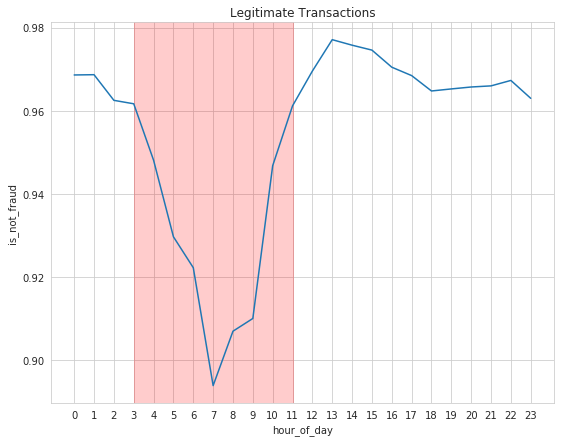

In [129]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 7)

g = sns.lineplot(x=temp.groupby('hour_of_day').mean()['is_not_fraud'].index, y=temp.groupby('hour_of_day').mean()['is_not_fraud'])
plt.title('Legitimate Transactions')
plt.xticks(np.arange(0,24))
plt.axvspan(3, 11, color='red', alpha=0.2)
plt.show()

We can see an exact opposite phenomenon when it comes to legitimate transactions. So, we can create a feature, that classifies a transaction and see if it was done between 3 ~ 11 span!!

Text(0.5, 1.0, 'Histogram of number of all transactions through out the day ')

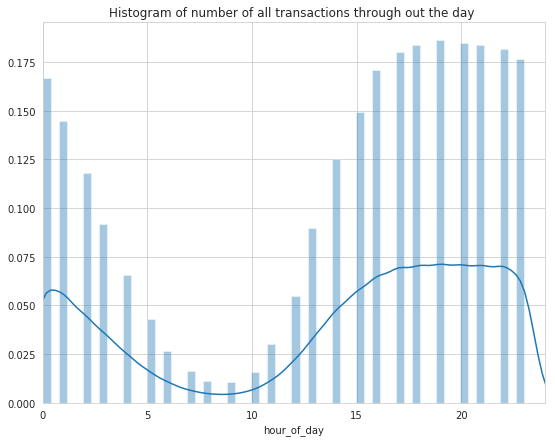

In [130]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 7)

sns.distplot(a=df['hour_of_day'], bins=60)
plt.xlim(0, 24)
plt.title('Histogram of number of all transactions through out the day ')

After encoding the time into a 24 hr format cyclical rounds, I found that according to the given time-zone, transactions spiked (now these are all transactions not just fradulent transactions) after 1500 hrs and stayed same till mid-night. Let's plot fradulent transactions and legit transactions separately.

In [131]:
df['hour_of_day'].corr(df['isFraud'])

-0.013112195075749086

Text(0.5, 1.0, 'Histogram of Fraud Transactions')

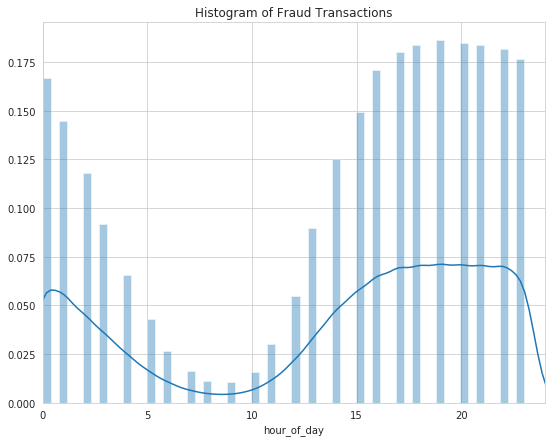

In [132]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 7)

sns.distplot(a=df['hour_of_day'], bins=60)
plt.xlim(0, 24)
plt.title('Histogram of Fraud Transactions')

Text(0.5, 1.0, 'Histogram of Legit Transactions')

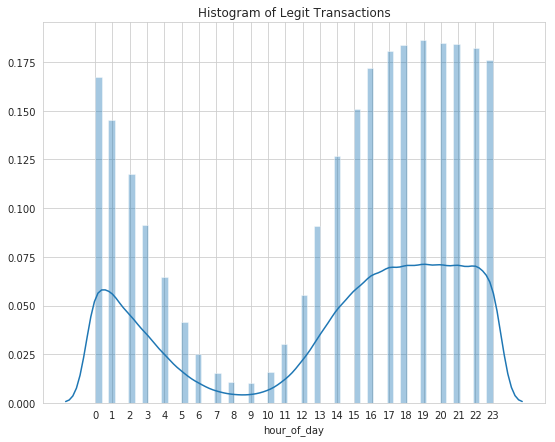

In [133]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 7)

sns.distplot(a=df['hour_of_day'][df.isFraud==0], bins=60)
plt.xticks(np.arange(24))
plt.title('Histogram of Legit Transactions')

**There seems to be a subtle difference between the Legit and fraud transactions, fraud transactions are more likely to occur in early morning slots slightly till 11 AM**   
Now Let's see what we catch with the transaction amount and the time of the transaction

**Co-relations between the hour-of-day and transaction amount**

In [134]:
# standard co-relation coefficient
df['hour_of_day'].corr(df['TransactionAmt'])

0.04453363285704813

**Spearman co-relation between the hour-of-day and transaction amount**

In [135]:
# spearman co-relation coefficient
print (df['hour_of_day'].corr(df['TransactionAmt'], method='spearman'))

0.03831564115458957


Text(0.5, 1.0, 'Legitimate transactions, without outliers')

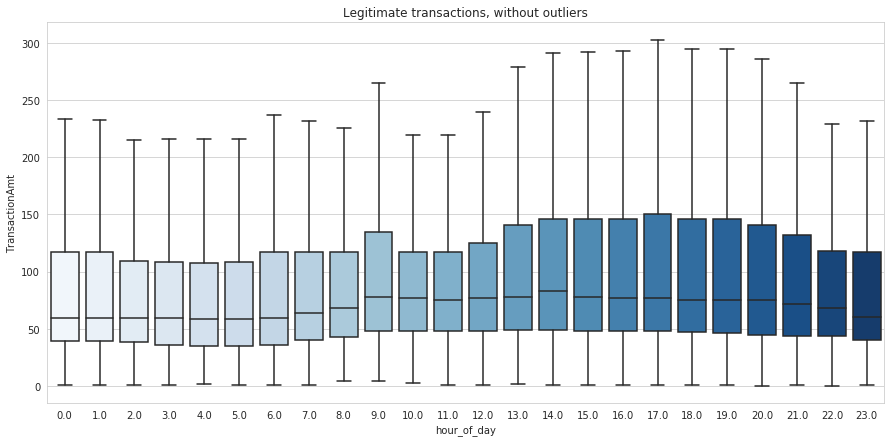

In [136]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 7)

g = sns.boxplot(x="hour_of_day", y='TransactionAmt', 
                   data=df.loc[df.isFraud==0],   palette="Blues", showfliers=False)

plt.title("Legitimate transactions, without outliers")
#g.set_xticklabels(rotation=90)
#plt.ylabel("Count in K (Log Scale)")  
#g.fig.get_axes()[0].set_yscale('log')

Text(0.5, 1.0, 'Fradulent transactions')

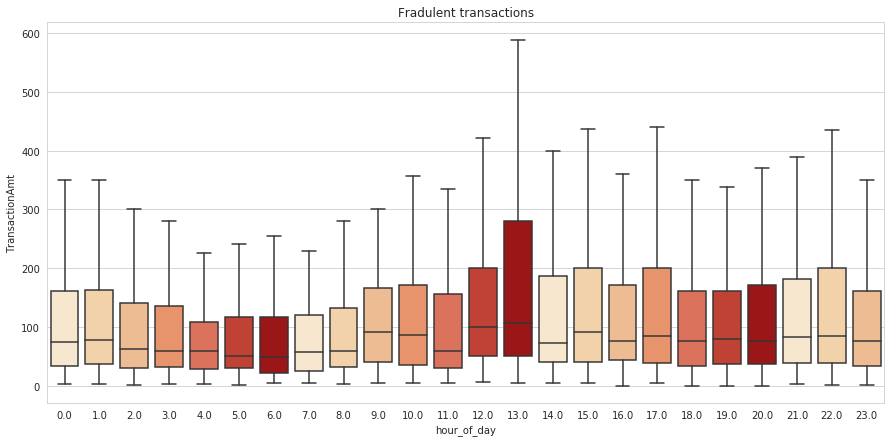

In [137]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 7)

g = sns.boxplot(x="hour_of_day", y='TransactionAmt', 
                   data=df.loc[df.isFraud==1], palette=sns.color_palette("OrRd", n_colors=7), color='r', showfliers=False)
plt.title('Fradulent transactions')

[]

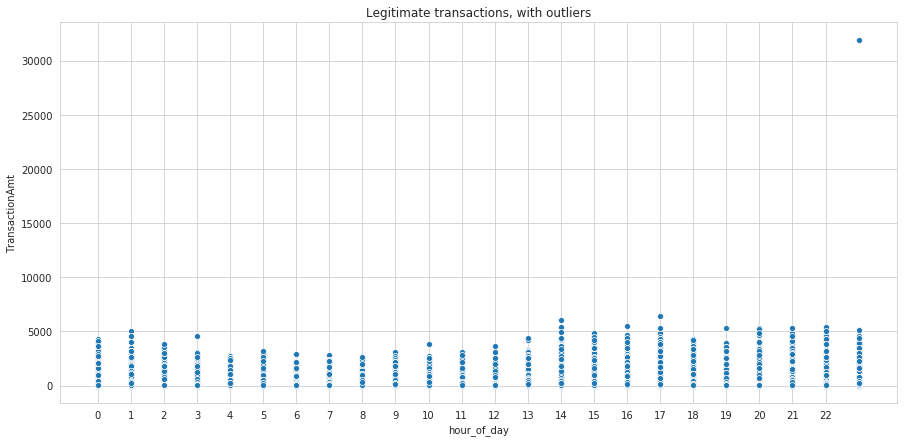

In [138]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 7)

g = sns.scatterplot(x="hour_of_day", y='TransactionAmt', 
                   data=df.loc[df.isFraud==0],   palette="Blues")

plt.title("Legitimate transactions, with outliers")
plt.xticks(np.arange(0,23))
plt.plot()

From above graphs, a small thing that is clear is that, any outlier above $5000 is mostly a legitimate transaction.

[]

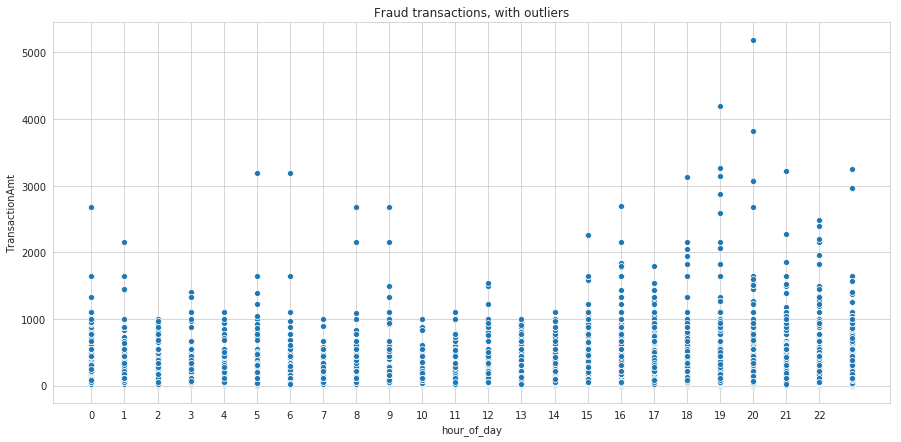

In [139]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 7)

g = sns.scatterplot(x="hour_of_day", y='TransactionAmt', 
                   data=df.loc[df.isFraud==1],   palette="Blues")

plt.title("Fraud transactions, with outliers")
plt.xticks(np.arange(0,23))
plt.plot()

**Day of the week feature**

In [0]:
def get_day_of_the_week(x):
  return np.round(x/3600*24)%7

In [0]:
df['Day_of_the_week'] = df['TransactionDT'].apply(get_day_of_the_week)

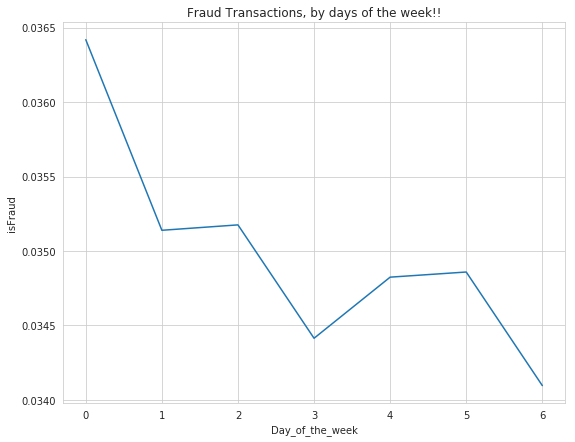

In [142]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 7)

sns.lineplot(x=df.groupby('Day_of_the_week').mean()['isFraud'].index, y=df.groupby('Day_of_the_week').mean()['isFraud'])
plt.title('Fraud Transactions, by days of the week!!')
plt.xticks(np.arange(0,7))

plt.show()

In [0]:
Day_of_the_week, is_not_fraud = df['Day_of_the_week'], df['isFraud'].apply(filter)

Day_of_the_week.name = 'Day_of_the_week'
is_not_fraud.name = 'is_not_fraud'
temp = pd.concat([Day_of_the_week, is_not_fraud], axis=1, sort=False)

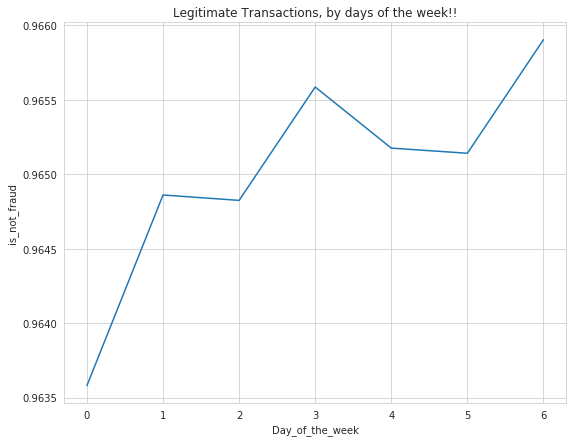

In [144]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 7)

g = sns.lineplot(x=temp.groupby('Day_of_the_week').mean()['is_not_fraud'].index, y=temp.groupby('Day_of_the_week').mean()['is_not_fraud'])
plt.title('Legitimate Transactions, by days of the week!!')
plt.xticks(np.arange(0,7))

plt.show()

**This looks exactly opposite to the fradulent transactions**   
Let's check the corelation coefficients

In [145]:
# spearman co-relation coefficient
df['Day_of_the_week'].corr(df['isFraud'], method='spearman')

-0.003067145927338872

In [146]:
# standard co-relation coefficient
df['Day_of_the_week'].corr(df['isFraud'])

-0.0030679620011329666

In [147]:
# standard co-relation coefficient
df['Day_of_the_week'].corr(df['TransactionAmt'])

0.0019985978633432168

[]

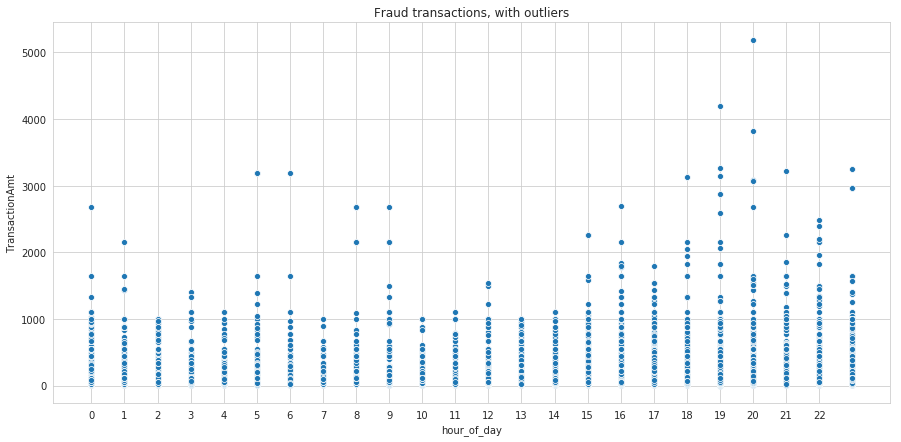

In [149]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 7)

g = sns.scatterplot(x="hour_of_day", y='TransactionAmt', 
                   data=most_freq.loc[most_freq.isFraud==1],   palette="Blues")

plt.title("Fraud transactions, with outliers")
plt.xticks(np.arange(0,23))
plt.plot()

[]

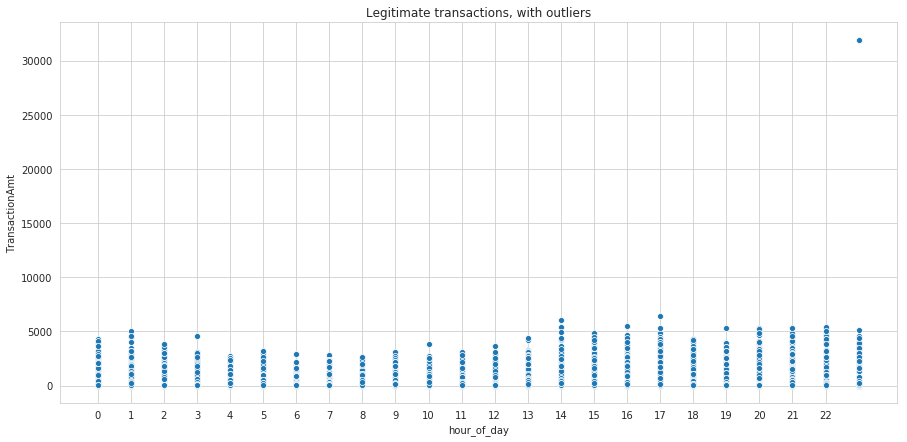

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 7)

g = sns.scatterplot(x="hour_of_day", y='TransactionAmt', 
                   data=most_freq.loc[most_freq.isFraud==0],   palette="Blues")

plt.title("Legitimate transactions, with outliers")
plt.xticks(np.arange(0,23))
plt.plot()

**From the above two figuers I conclude that data related to addr2=87.0 kind of governs the distributions and patterns.**

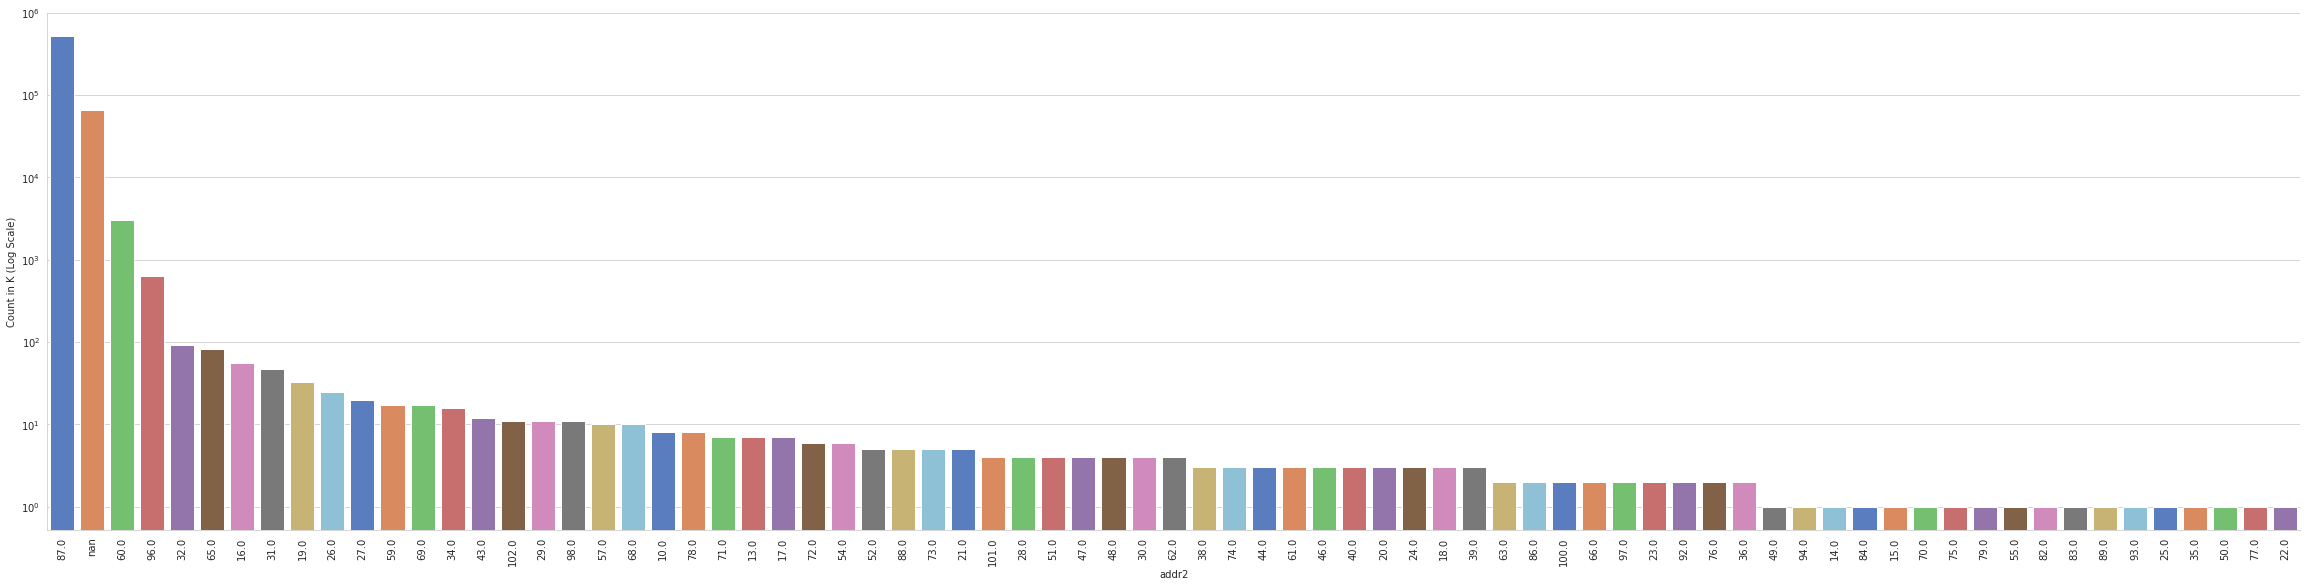

In [0]:
g = sns.factorplot(x="addr2", kind='count', orient='v',
                   data=df, palette="muted", log=True, order=df.addr2.value_counts().iloc[:75].index, size=8, aspect=4)

g.set_xticklabels(rotation=90)
plt.ylabel("Count in K (Log Scale)")  
g.fig.get_axes()[0].set_yscale('log')

The most frequent country code is `87` let's dig deeper into it

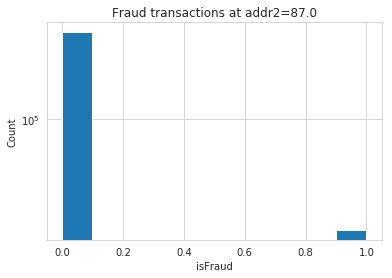

In [0]:
#sns.distplot(a=most_freq.isFraud)
plt.hist(most_freq['isFraud'])
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('isFraud')
plt.title('Fraud transactions at addr2=87.0')
plt.show()

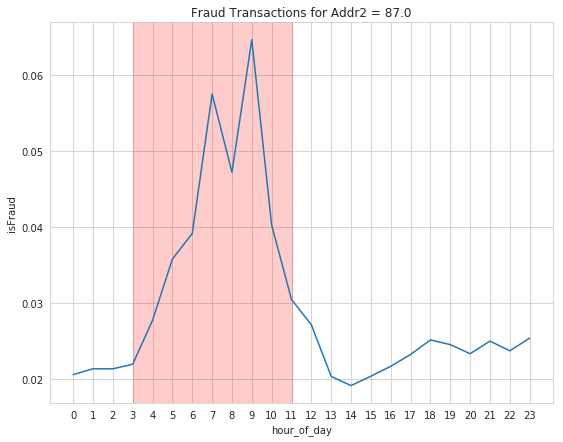

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 7)

sns.lineplot(x=most_freq.groupby('hour_of_day').mean()['isFraud'].index, y=most_freq.groupby('hour_of_day').mean()['isFraud'])
plt.title('Fraud Transactions for Addr2 = 87.0')
plt.xticks(np.arange(0,24))
plt.axvspan(3, 11, color='red', alpha=0.2)
plt.show()

In [0]:
hour_of_day, is_not_fraud = most_freq['hour_of_day'], most_freq['isFraud'].apply(filter)

In [0]:
hour_of_day.name = 'hour_of_day'
is_not_fraud.name = 'is_not_fraud'
temp = pd.concat([hour_of_day, is_not_fraud], axis=1, sort=False)

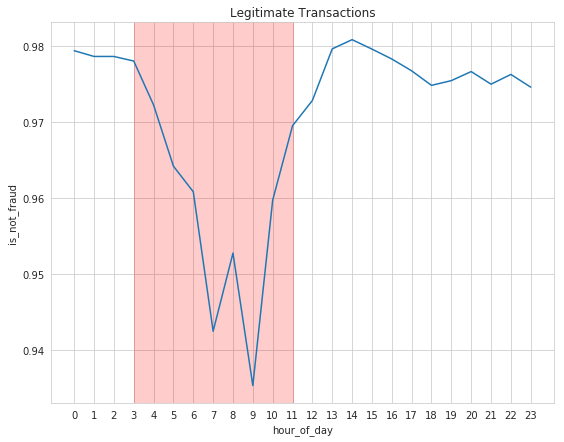

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 7)

g = sns.lineplot(x=temp.groupby('hour_of_day').mean()['is_not_fraud'].index, y=temp.groupby('hour_of_day').mean()['is_not_fraud'])
plt.title('Legitimate Transactions')
plt.xticks(np.arange(0,24))
plt.axvspan(3, 11, color='red', alpha=0.2)
plt.show()

**We can concluded that at there could be night time during 300 hrs to 11 hrs in the location which is to frequent here 87.0**

# One Interesting plot and it's meaning [Q]

(0, 15)

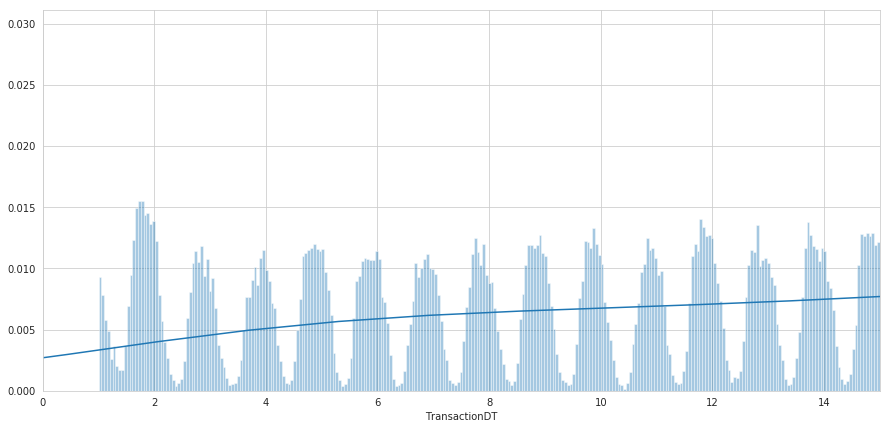

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 7)

sns.distplot(df['TransactionDT']/(3600*24), bins=3600)

plt.xlim(0, 15)

**I find this plot really interesting, because, it show-cases that the periodicity among the transactions (all) it strongly provides evidence to the difference between transaction volumes at certain times during the day!!**

In [0]:
from fastai.tabular import transform

In [0]:
temp = df.copy(deep=True)

In [0]:
#transform.add_datepart(temp, 'TransactionDT')
print (temp.head())

   TransactionID DeviceType  ... hour_of_day  Day_of_the_week
0        2987004     mobile  ...         0.0              3.0
1        2987008     mobile  ...         0.0              3.0
2        2987010    desktop  ...         0.0              3.0
3        2987011    desktop  ...         0.0              3.0
4        2987016    desktop  ...         0.0              3.0

[5 rows x 17 columns]


https://www.experian.com/blogs/ask-experian/the-history-of-credit-cards/#targetText=The%20modern%20payment%20card%20was,month's%20statement%20balance%20in%20full.

According first modern credit cards were used from 1980s so, if we take traditional conversion for dates, it starts from 1970. So, clearly the dates used here are from a random chunk of time (mostly recent times)

# Build Models




> Prepared data set by proper feature engineering (create some new features, modify data types, encodings etc.)
> Create train, validation and test bunch
> Set off for API calling (i.e building models ;-))



In [150]:
print (df.shape)
display_all(df.columns)

(590540, 17)


Index(['TransactionID', 'DeviceType', 'DeviceInfo', 'TransactionDT',
       'TransactionAmt', 'ProductCD', 'card4', 'card6', 'P_emaildomain',
       'R_emaildomain', 'addr1', 'addr2', 'dist1', 'dist2', 'isFraud',
       'hour_of_day', 'Day_of_the_week'],
      dtype='object')


**Feature Engineering**
*   Remove `TransactionID`, `TransactionDT`
*   Split emails into new features `Len_ID`, `Domain`
*   Create new feature `time_at_night` for transactions executed during `300 hrs - 1100 hrs`
*   I will start with tree based modelling as they do well on a lot of categorial variables.



In [0]:
# Read in the test set
test_tr = pd.read_csv('My Drive/DataScience/IEEE Fraud Detection/test_transaction.csv.zip')
test_id = pd.read_csv('My Drive/DataScience/IEEE Fraud Detection/test_identity.csv.zip')

In [152]:
##Let's check if they both contain same rows
print (test_id.shape)
print (test_tr.shape)

(141907, 41)
(506691, 393)


**Let's leave the null values as is**

In [153]:
display_all(test_id.isna().sum()*100/test_id.shape[0])

TransactionID     0.000000
id_01             0.000000
id_02             3.474811
id_03            53.151712
id_04            53.151712
id_05             5.043444
id_06             5.043444
id_07            96.434989
id_08            96.434989
id_09            47.614987
id_10            47.614987
id_11             3.614339
id_12             0.000000
id_13             8.189166
id_14            49.715659
id_15             3.474106
id_16            11.387740
id_17             4.186545
id_18            64.149055
id_19             4.228826
id_20             4.421205
id_21            96.434989
id_22            96.432875
id_23            96.432875
id_24            96.659784
id_25            96.449083
id_26            96.443445
id_27            96.432875
id_28             3.614339
id_29             3.614339
id_30            50.207530
id_31             3.722156
id_32            50.199074
id_33            50.199074
id_34            49.139225
id_35             3.474106
id_36             3.474106
i

In [0]:
test = test_id.merge(test_tr, how='outer', on='TransactionID')

In [155]:
print (test.shape)
import gc
test_id = None
test_tr = None
gc.collect()

(506691, 433)


13543

In [156]:
attr.remove("isFraud")
test = test[attr]
gc.collect()

7

In [157]:
print (test.shape)

display_all(test.columns)
display_all(df.columns)

(506691, 14)


Index(['TransactionID', 'DeviceType', 'DeviceInfo', 'TransactionDT',
       'TransactionAmt', 'ProductCD', 'card4', 'card6', 'P_emaildomain',
       'R_emaildomain', 'addr1', 'addr2', 'dist1', 'dist2'],
      dtype='object')

Index(['TransactionID', 'DeviceType', 'DeviceInfo', 'TransactionDT',
       'TransactionAmt', 'ProductCD', 'card4', 'card6', 'P_emaildomain',
       'R_emaildomain', 'addr1', 'addr2', 'dist1', 'dist2', 'isFraud',
       'hour_of_day', 'Day_of_the_week'],
      dtype='object')

In [0]:
test['hour_of_day'] = get_hour_of_day(test.TransactionDT)
test['Day_of_the_week'] = get_day_of_the_week(test.TransactionDT)

In [0]:
test['DeviceType'].fillna(value='nan', inplace=True)
test['dist2'].fillna(value='nan', inplace=True)
test['dist1'].fillna(value='nan', inplace=True)
test['R_emaildomain'].fillna(value='nan', inplace=True)
test['P_emaildomain'].fillna(value='nan', inplace=True)
test['card6'].fillna(value='nan', inplace=True)
test['card4'].fillna(value='nan', inplace=True)
test['DeviceInfo'].fillna(value='nan', inplace=True)

In [160]:
print (df.shape)
print (test.shape)

(590540, 17)
(506691, 16)


In [0]:
def get_is_night(col):
  if col >=3 and col <=11:
    return True
  return False

# Create new features...

In [0]:
df['is_night'] = df['hour_of_day'].apply(get_is_night)
test['is_night'] = test['hour_of_day'].apply(get_is_night)

In [0]:
temp = df.P_emaildomain[np.random.random_integers(0, 1000, size=100)]

In [0]:
def get_len(x):
  return len(x[0])

In [0]:
df['len_P_email'] = df.P_emaildomain.apply(len)
test['len_P_email'] = test.P_emaildomain.apply(len)
df['len_R_email'] = df.R_emaildomain.apply(len)
test['len_R_email'] = test.R_emaildomain.apply(len)

Let's find out the lenghts of the email addresses and check if there is any connection with the `isFraud` variable.

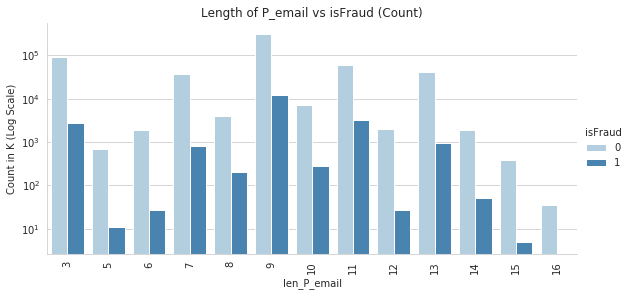

In [166]:
g = sns.factorplot(x="len_P_email", hue="isFraud", kind='count', orient='v',
                   data=df, palette="Blues", log=True,  size=4, aspect=2)

g.set_xticklabels(rotation=90)
plt.title('Length of P_email vs isFraud (Count)')
plt.ylabel("Count in K (Log Scale)")  
g.fig.get_axes()[0].set_yscale('log')
#g = sns.countplot(x='len_P_email', hue='isFraud', data=df)

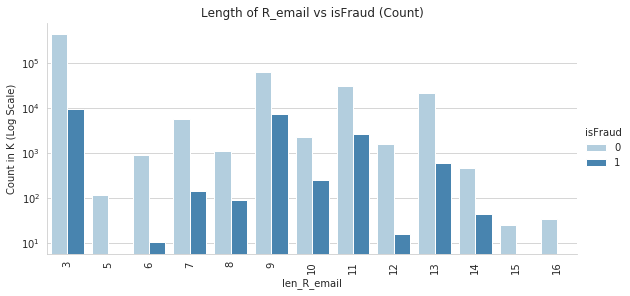

In [167]:
g = sns.factorplot(x="len_R_email", hue="isFraud", kind='count', orient='v',
                   data=df, palette="Blues", log=True,  size=4, aspect=2)

g.set_xticklabels(rotation=90)
plt.ylabel("Count in K (Log Scale)")  
plt.title('Length of R_email vs isFraud (Count)')
g.fig.get_axes()[0].set_yscale('log')

In [0]:
def get_tld(x):
  return x[-1]

In [0]:
df['tld_P_email'] = df.P_emaildomain.str.split('.').apply(get_tld)

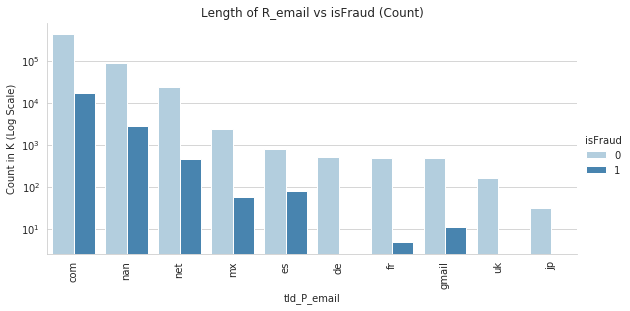

In [170]:
g = sns.factorplot(x="tld_P_email", hue="isFraud", kind='count', orient='v',
                   data=df, palette="Blues", log=True,  size=4, aspect=2)

g.set_xticklabels(rotation=90)
plt.ylabel("Count in K (Log Scale)")  
plt.title('Length of R_email vs isFraud (Count)')
g.fig.get_axes()[0].set_yscale('log')

In [0]:
df['tld_R_email'] = df.P_emaildomain.str.split('.').apply(get_tld)

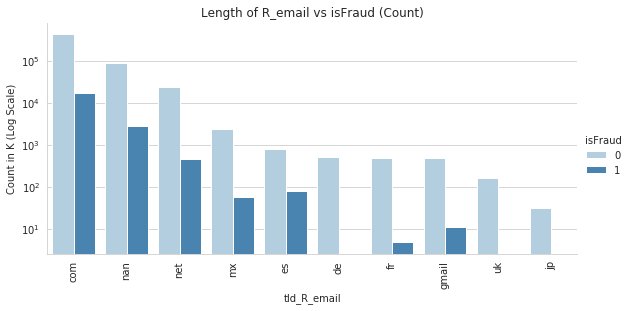

In [172]:
g = sns.factorplot(x="tld_R_email", hue="isFraud", kind='count', orient='v',
                   data=df, palette="Blues", log=True,  size=4, aspect=2)

g.set_xticklabels(rotation=90)
plt.ylabel("Count in K (Log Scale)")  
plt.title('Length of R_email vs isFraud (Count)')
g.fig.get_axes()[0].set_yscale('log')

In [173]:
df.tld_R_email.value_counts()

com      466477
nan       94456
net       24542
mx         2499
es          877
de          506
gmail       496
fr          494
uk          161
jp           32
Name: tld_R_email, dtype: int64

**The above two attributes are not added to the model as they may lead to bias towards the training set!! So, dropping them. They also don't possess significant predictive power**

In [0]:
df.drop(columns=['tld_R_email', 'tld_P_email'], inplace=True)

# Submission.csv 

In [0]:
def get_labels(x):
  if x > 0.5:
    return 1
  return 0

def make_submission(clf, test, name, model):
  sub = pd.read_csv('My Drive/DataScience/IEEE Fraud Detection/sample_submission.csv.zip', compression='zip')
  if model =='xg':
    proba = clf.predict_proba(test)
    labels = clf.predict(test)
    print (np.sum(labels))
  else:
    proba = clf.predict(test)
    labels = pd.Series(proba).apply(get_labels)
    print (np.sum(labels))
  sub['isFraud'] = proba
  sub.to_csv('My Drive/DataScience/IEEE Fraud Detection/'+name+'.csv', index=False)

# Partitioning the dataset

In [175]:
display_all(df.dtypes)

TransactionID        int32
DeviceType          object
DeviceInfo          object
TransactionDT        int32
TransactionAmt     float16
ProductCD           object
card4               object
card6               object
P_emaildomain       object
R_emaildomain       object
addr1               object
addr2               object
dist1               object
dist2               object
isFraud               int8
hour_of_day        float64
Day_of_the_week    float64
is_night              bool
len_P_email          int64
len_R_email          int64
dtype: object

In [0]:
place_holders = []
cols = []
for col in df.columns:
  if df[col].dtype == 'object':
    place_holders.append('nan')
    
  elif df[col].dtype == 'bool':
    place_holders.append(True)
  else:
    place_holders.append(0)
  cols.append(col)

In [0]:
df.append(pd.DataFrame([place_holders], columns=cols), ignore_index=True)

Convert strings to int types using LabelEncoder
I'll be mainly using Tree based Models, so they work fine with a lot of missing data.

In [178]:
from sklearn.preprocessing import LabelEncoder
encoders = {}
for col in df.columns:
  if df[col].dtype == 'object':
    le = LabelEncoder()
    print ("Processing col - "+col)
    df[col] = df[col].astype('str')
    test[col] = test[col].astype('str')
    le.fit(df[col])
    df[col] = le.transform(df[col])
    test[col] = test[col].map(lambda s: 'nan' if s not in le.classes_ else s)
    test[col] = le.transform(test[col])
    encoders[col] = le

Processing col - DeviceType
Processing col - DeviceInfo
Processing col - ProductCD
Processing col - card4
Processing col - card6
Processing col - P_emaildomain
Processing col - R_emaildomain
Processing col - addr1
Processing col - addr2
Processing col - dist1
Processing col - dist2


In [179]:
df.tail(2)

TransactionID  DeviceType  ...  len_P_email  len_R_email
590538        3577538           2  ...            7            3
590539        3577539           2  ...            9            3

[2 rows x 20 columns]

In [181]:
""" This snippet has to be executed only once as it saves the data set in processed form
df.to_csv('My Drive/DataScience/IEEE Fraud Detection/train_processed.csv.zip', compression='zip')
test.to_csv('My Drive/DataScience/IEEE Fraud Detection/test_processed.csv.zip', compression='zip')"""

" This snippet has to be executed only once as it saves the data set in processed form\ndf.to_csv('My Drive/DataScience/IEEE Fraud Detection/train_processed.csv.zip', compression='zip')\ntest.to_csv('My Drive/DataScience/IEEE Fraud Detection/test_processed.csv.zip', compression='zip')"

In [0]:
y = df['isFraud']
X = df.drop(columns=['isFraud', 'TransactionID', 'TransactionDT'])

**Split the data and build the model**

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [184]:
df.isFraud.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [0]:
import lightgbm as lgb

d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_valid, label=y_valid)
d_test = lgb.Dataset(X_test, label=y_test)
d_test_all = lgb.Dataset(test.drop(columns=['TransactionID', 'TransactionDT']))
params = {}

params['learning_rate'] = 0.3
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'auc'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 6
params['scale_pos_weight'] = 99.65
## Default Model with our subset of attributes.
clf = lgb.train(params, d_train)

In [199]:
make_submission(clf, test.drop(columns=['TransactionID', 'TransactionDT']), 'naive_model', 'lgb')

345621


In [200]:
# Model 2
# Max Depth 9 and with cross-validation
# Max estimators 1000

import lightgbm as lgb

d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_valid, label=y_valid)
d_test = lgb.Dataset(X_test, label=y_test)
d_test_all = lgb.Dataset(test.drop(columns=['TransactionID', 'TransactionDT']))
params = {}

params['learning_rate'] = 0.3
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'auc'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 9
params['scale_pos_weight'] = 99.65
## Default Model with our subset of attributes.
clf2 = lgb.train(params, d_train)

clf2 = lgb.train(params, d_train, num_boost_round=1000, valid_sets=[d_valid], early_stopping_rounds=2, verbose_eval=True)

[1]	valid_0's auc: 0.702879
Training until validation scores don't improve for 2 rounds.
[2]	valid_0's auc: 0.70681
[3]	valid_0's auc: 0.736392
[4]	valid_0's auc: 0.740877
[5]	valid_0's auc: 0.761977
[6]	valid_0's auc: 0.76273
[7]	valid_0's auc: 0.768061
[8]	valid_0's auc: 0.771782
[9]	valid_0's auc: 0.778431
[10]	valid_0's auc: 0.78254
[11]	valid_0's auc: 0.784475
[12]	valid_0's auc: 0.785605
[13]	valid_0's auc: 0.788023
[14]	valid_0's auc: 0.789457
[15]	valid_0's auc: 0.791151
[16]	valid_0's auc: 0.793137
[17]	valid_0's auc: 0.794124
[18]	valid_0's auc: 0.795078
[19]	valid_0's auc: 0.796441
[20]	valid_0's auc: 0.797647
[21]	valid_0's auc: 0.798843
[22]	valid_0's auc: 0.800326
[23]	valid_0's auc: 0.800772
[24]	valid_0's auc: 0.801664
[25]	valid_0's auc: 0.802498
[26]	valid_0's auc: 0.803017
[27]	valid_0's auc: 0.804455
[28]	valid_0's auc: 0.805358
[29]	valid_0's auc: 0.805719
[30]	valid_0's auc: 0.806029
[31]	valid_0's auc: 0.80681
[32]	valid_0's auc: 0.807447
[33]	valid_0's auc: 0.80

In [201]:
## This function outputs a file into my google drive from which I later submit it to Kaggle. I will lead to errors after running it directly without modifications.
make_submission(clf2, test.drop(columns=['TransactionID', 'TransactionDT']), 'naive_model_2', 'lgb')

222061


# Results on the leaderboard

[Imgur](https://imgur.com/NdpKIer) . Leaderboard Snapshot

[Imgur](https://imgur.com/vbGnM4w) clf2 model

[Imgur](https://imgur.com/kD47Sdt) You can see the latest score as 0.5027 as my latest score on the leaderboard after submissing the previous results. (I had worked on this problem eariler before attending Stony Brook, so I'm not submitting my previous work (which reflects my present rank) the work in this notebook has been entirely re-done from scratch!!

# Other Experiments


*   A model with all attributes
*   Feature ranking




In [0]:
## This code needs to be executed only once! The processed data set is stored as CSV into my google drive 
"""
test_tr = pd.read_csv('My Drive/DataScience/IEEE Fraud Detection/test_transaction.csv.zip', index_col='TransactionID')
test_id = pd.read_csv('My Drive/DataScience/IEEE Fraud Detection/test_identity.csv.zip', index_col='TransactionID')
test = test_tr.merge(test_id, how='left', left_index=True, right_index=True)
print(test.shape)
X_test = test.copy()
#X_test = X_test.fillna(-20000)
X_test = reduce_mem_usage(X_test)
del test_tr, test_id, test
gc.collect()"""

(506691, 432)
Memory usage of dataframe is 1673.87 MB --> 563.43 MB (Decreased by 66.3%)


21

In [0]:
## This code needs to be executed only once! The processed data set is stored as CSV into my google drive
"""lbl = LabelEncoder()
train['ProductCD'] = train.astype('str')
X_test['ProductCD'] = X_test.astype('str')
lbl.fit(set(train['ProductCD'].values).union(set(X_test['ProductCD'].values)))
train['ProductCD'] = lbl.transform(train['ProductCD'])
X_test['ProductCD'] = lbl.transform(X_test['ProductCD'])"""

In [0]:
# Label Encoding
""" Only to be executed once
from sklearn.preprocessing import LabelEncoder
for col in train.columns:
  if train[col].dtype=='object' or X_test[col].dtype=='object':
    print ("Processing "+col)
    lbl = LabelEncoder()
    train[col] = train.astype('str')
    X_test[col] = X_test.astype('str')
    lbl.fit(list(train[col].values)+list(X_test[col].values))
    train[col] = lbl.transform(train[col])
    X_test[col] = lbl.transform(X_test[col])
    lbl = None
    gc.collect()
  else :
    train.fillna(-20000)
    X_test.fillna(-20000)
The processed data is saved into csv files.
"""

Processing ProductCD
Processing card4
Processing card6
Processing P_emaildomain
Processing R_emaildomain
Processing M1
Processing M2
Processing M3
Processing M4
Processing M5
Processing M6
Processing M7
Processing M8
Processing M9
Processing id_12
Processing id_15
Processing id_16
Processing id_23
Processing id_27
Processing id_28
Processing id_29
Processing id_30
Processing id_31
Processing id_33
Processing id_34
Processing id_35
Processing id_36
Processing id_37
Processing id_38
Processing DeviceType
Processing DeviceInfo


In [0]:
print (train.head())

               TransactionDT  TransactionAmt  ...  DeviceType  DeviceInfo
TransactionID                                 ...                        
2987000                86400            68.5  ...     1017844     1017844
2987001                86401            29.0  ...     1017848     1017848
2987002                86469            59.0  ...     1018317     1018317
2987003                86499            50.0  ...     1018495     1018495
2987004                86506            50.0  ...     1018526     1018526

[5 rows x 432 columns]


In [1]:
## This piece of code is ran only once, to write the processed data set
"""
train.to_csv('My Drive/DataScience/IEEE Fraud Detection/processed_train.csv.zip', compression='zip')
X_test.to_csv('My Drive/DataScience/IEEE Fraud Detection/processed_test.csv.zip', compression='zip')
"""

"\ntrain.to_csv('My Drive/DataScience/IEEE Fraud Detection/processed_train.csv.zip', compression='zip')\nX_test.to_csv('My Drive/DataScience/IEEE Fraud Detection/processed_test.csv.zip', compression='zip')\n"

In [202]:
## Clearing the variables and the data from the previous Run
test = None
df = None
gc.collect()

12959

In [0]:
## Read the processed data from the google drive
train = pd.read_csv('My Drive/DataScience/IEEE Fraud Detection/processed_train.csv.zip', index_col='TransactionID')
test = pd.read_csv('My Drive/DataScience/IEEE Fraud Detection/processed_test.csv.zip', index_col='TransactionID')
y = pd.read_csv('My Drive/DataScience/IEEE Fraud Detection/train_transaction.csv.zip', usecols=['isFraud'])

In [204]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 1950.87 MB --> 577.83 MB (Decreased by 70.4%)
Memory usage of dataframe is 1673.87 MB --> 503.51 MB (Decreased by 69.9%)


In [0]:
## Build an naive XGBoost Classifier
clfX = xgb.XGBClassifier(n_estimators=100, max_depth=9, verbosity = 3, random_state = 13, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, missing=np.nan, tree_method='gpu_hist')

In [212]:
clfX.fit(train, y, verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=13,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, tree_method='gpu_hist', verbosity=3)

In [213]:
make_submission(clfX,test,'naive_XGB', clfX)

9048


[Imgur](https://imgur.com/p6xUAmS) First submission Naive XGB 0.7335

In [214]:
## Second trial with XGBoost
clfX = xgb.XGBClassifier(n_estimators=500, max_depth=9, verbosity = 3, random_state = 13, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9, missing=np.nan, tree_method='gpu_hist')
clfX.fit(train, y, verbose=True, eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=13,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, tree_method='gpu_hist', verbosity=3)

In [215]:
make_submission(clfX,test,'better_XGB', clfX)

9159


[Imgur](https://imgur.com/6JNAc8W) This one is a slight improvement over the other

# One more interesting Plots regarding the whole data set
This plot show the important features as pointed by our naive XGBoost model from among the whole data set.

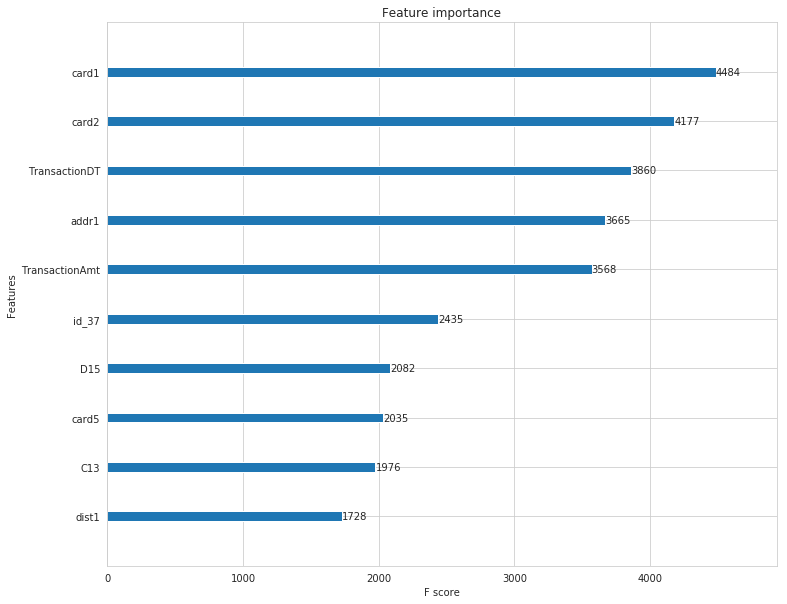

In [216]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)

xgb.plot_importance(clfX, ax=ax, max_num_features=10)
plt.show()

In [0]:
## New Model with new features
gc.collect()
train['hour_of_day'] = train['TransactionDT'].apply(get_hour_of_day)
train['day_of_week'] = train['TransactionDT'].apply(get_day_of_the_week)

test['hour_of_day'] = test['TransactionDT'].apply(get_hour_of_day)
test['day_of_week'] = test['TransactionDT'].apply(get_day_of_the_week)

train['is_night'] = train['hour_of_day'].apply(get_is_night)
test['is_night'] = test['hour_of_day'].apply(get_is_night)

In [0]:
clf2 = xgb.XGBClassifier(n_estimators=500, n_jobs=4, max_depth=9, verbosity = 2, random_state = 13, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9, missing=np.nan, tree_method='gpu_hist')

In [219]:
clf2.fit(train, y, verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=13,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, tree_method='gpu_hist', verbosity=2)

In [220]:
make_submission(clf2, test, 'big_model_xgb', 'xg')

9273


[Imgur](https://imgur.com/E5IZcnN) Last submission

Kaggle handle - niranjan1995

# Acknowledgements



1.   Seaborn Documentation
2.   Scikit-learn, pandas, numpy, LightGBM, XGBoost Documentations
3.   Random trouble shooting & error fixing : Stack Overflow

